# Repetit.ru

*ФИО: Смоляк П.В.*

*Telegram: @Smolchonok*

----------

### Заказчик:
##### Сервис по подбору репетиторов Repetit.ru

-----

### Описание проекта: 
Сервис передает контакты клиента (ученика) репетитору. Если репетитор начинает заниматься с учеником, то он должен платить сервису комиссию от каждого занятия. Но в реальности так происходит не всегда. Иногда, это из-за того, что репетитор звонит по телефону и ему просто не отвечают. Некоторые репетиторы плохо договариваются о занятиях или обманывают. Сервис теряет деньги каждый раз, когда отдаёт заявку неэффективному репетитору. Заказчику нужно как можно раньше понять, что репетитор недобросовестный или мошенник, чтобы отключить его от сервиса и отдавать заявки ответственным репетиторам.

Сейчас эта задача решается ручным просмотром сотрудниками или никак


##### **Содержание:**

- [Статистика по репетиторам и таргет (teachers.feather)](#1)
- [Информация о репетиторах (teacher_info.feather)](#2)
- [Ученики (lesson_course.feather)](#3)
- [Занятия (lessons.feather)](#4)
- [Цены на занятия репетиторов (teacher_prices.feather)](#5)
- [Заявки (orders.feather)](#6)
- [Отбор признаков](#7)
- [CatBoostClassifier](#8)
- [RandomForestClassifier](#9)
- [Подведём итоги](#10)

### Задачи: 
• Разработать модель, которая по имеющейся информации о репетиторе и проведенных им занятий будет классифицировать репетиторов на платящих и неэффективных.



#### Метрика: 
• для оценки качества разработанной модели будет использоваться F1-score.


**Описание таблиц: см.в файле description.txt**

Загрузим и посмотрим на общую информацию в данных:

In [981]:
!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

In [255]:
from catboost import CatBoostClassifier, Pool
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy import stats
from datetime import datetime

---

### Статистика по репетиторам и таргет (teachers.feather) 
<a id='1'></a>


In [4]:
teachers = pd.read_feather('teachers.feather')

In [5]:
teachers.head()

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0
1,153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0
2,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0
3,127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0
4,283905,694.0,1252.434457,534.0,0.257143,59.333333,668800.0,0


In [6]:
teachers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1656 non-null   int64  
 1   lessons_delivered         1656 non-null   float64
 2   mean_lesson_price         1656 non-null   float64
 3   lessons_given             1656 non-null   float64
 4   lessons_started_fraction  1656 non-null   float64
 5   lessons_per_pupil         1656 non-null   float64
 6   money_recieved            1656 non-null   float64
 7   blocked                   1656 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 103.6 KB


Пропусков нет, радует).

Формат float стоит у большинства колонок, переведём колонки в целочисленные где это возможно и логично, остальные, которые содержат информацию с процентами округлим. 


In [7]:
teachers.mean_lesson_price = round(teachers.mean_lesson_price, 2)
teachers.lessons_started_fraction = round(teachers.lessons_started_fraction, 4)
teachers.lessons_per_pupil = round(teachers.lessons_per_pupil)

In [8]:
teachers[['lessons_delivered', 'lessons_given', 'lessons_per_pupil', 'money_recieved']] = teachers[['lessons_delivered', 'lessons_given', \
                                                                                                    'lessons_per_pupil', 'money_recieved']].astype('int')

In [9]:
teachers.head()

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
0,198013,470,1284.22,469,0.6667,78,602300,0
1,153845,1111,884.09,1082,0.3590,77,956580,0
2,42869,505,2500.00,184,0.1429,61,460000,0
3,127280,442,1879.34,363,0.1500,60,682200,0
4,283905,694,1252.43,534,0.2571,59,668800,0


In [10]:
teachers.nunique()

id                          1656
lessons_delivered            493
mean_lesson_price           1105
lessons_given                370
lessons_started_fraction     548
lessons_per_pupil             57
money_recieved              1061
blocked                        2
dtype: int64

### Информация о репетиторах (teacher_info.feather) <a id='2'></a>


In [12]:
teacher_info = pd.read_feather('teachers_info.feather')

In [13]:
teacher_info.head()

,id,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num
0,33,2007-12-24 19:26:46.000,1983-06-05 00:00:00.000,1989-09-01 00:00:00.000,0,60,1000,1,2022-10-24 16:48:38.410,1.0,0,1,1,0,6
1,46,2007-12-24 19:26:46.000,1980-02-12 00:00:00.000,2003-09-01 00:00:00.000,0,60,500,0,None,1.0,0,1,3,1,0
2,51,2007-12-24 19:26:46.000,1965-04-30 00:00:00.000,1988-09-01 00:00:00.000,0,60,1500,0,2022-09-26 09:43:56.123,1.0,0,1,2,1,0
3,52,2007-12-24 19:26:46.000,1988-07-06 00:00:00.000,2006-09-01 00:00:00.000,0,60,1000,1,2020-04-03 15:53:50.867,0.0,0,1,2,1,2
4,54,2007-12-24 19:26:46.000,1985-09-30 00:00:00.000,2004-01-01 00:00:00.000,0,45,400,0,None,1.0,0,1,3,1,0


In [14]:
teacher_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       307972 non-null  int64  
 1   reg_date                 307972 non-null  object 
 2   birth_date               307972 non-null  object 
 3   teaching_start_date      307972 non-null  object 
 4   is_email_confirmed       307972 non-null  int64  
 5   lesson_duration          307972 non-null  int64  
 6   lesson_cost              307972 non-null  int64  
 7   is_display               307972 non-null  int64  
 8   last_visited             235837 non-null  object 
 9   is_pupils_needed         11208 non-null   float64
 10  is_cell_phone_confirmed  307972 non-null  int64  
 11  area_id                  307972 non-null  int64  
 12  sex                      307972 non-null  int64  
 13  orders_allowed           307972 non-null  int64  
 14  revi

Колонка категориальная с информацией о открытости к заявкам имеет только 2 значения 0 и 1, проверим так ли это и посмотрим на количество пропусков в ней

In [15]:
print(teacher_info.loc[:, teacher_info.isnull().any()].isnull().sum())

pd.DataFrame(round(teacher_info.loc[:, teacher_info.isnull().any()].isnull().mean()*100,3)).style.background_gradient('coolwarm')

last_visited         72135
is_pupils_needed    296764
dtype: int64


,0
last_visited,23.423000
is_pupils_needed,96.361000


Поропуски по колонкам last_visited - последний визит и is_pupils_needed - открыт для заявок. Причём в колонке с информацией о открытости репетитора к заявкам пропуски занимают более 96 %, поэтому считаю данный столбец не информативным и предлагаю его удалить.

In [16]:
teacher_info.drop('is_pupils_needed', axis=1, inplace=True)

В данных теперь есть только пропуски по колонке с информацией последнего визита

Даты также не правильно распознаются даты, исправим на  формат datetime

In [17]:
teacher_info[teacher_info.select_dtypes(include=['object']).columns.tolist()].head()

,reg_date,birth_date,teaching_start_date,last_visited
0,2007-12-24 19:26:46.000,1983-06-05 00:00:00.000,1989-09-01 00:00:00.000,2022-10-24 16:48:38.410
1,2007-12-24 19:26:46.000,1980-02-12 00:00:00.000,2003-09-01 00:00:00.000,None
2,2007-12-24 19:26:46.000,1965-04-30 00:00:00.000,1988-09-01 00:00:00.000,2022-09-26 09:43:56.123
3,2007-12-24 19:26:46.000,1988-07-06 00:00:00.000,2006-09-01 00:00:00.000,2020-04-03 15:53:50.867
4,2007-12-24 19:26:46.000,1985-09-30 00:00:00.000,2004-01-01 00:00:00.000,None


В колонках указан разный часовой пояс, приведу к единому, удобному при анализе.

In [18]:
teacher_info['reg_date'] = pd.to_datetime(teacher_info['reg_date']).dt.tz_localize('UTC')
teacher_info['birth_date'] = pd.to_datetime(teacher_info['birth_date']).dt.tz_localize('UTC')
teacher_info['teaching_start_date'] = pd.to_datetime(teacher_info['teaching_start_date']).dt.tz_localize('UTC')
teacher_info['last_visited'] = pd.to_datetime(teacher_info['last_visited']).dt.tz_localize('UTC')

In [20]:
teacher_info[teacher_info.last_visited.isnull()].nunique()

id                         72135
reg_date                   72082
birth_date                 15795
teaching_start_date          562
is_email_confirmed             2
lesson_duration               96
lesson_cost                  219
is_display                     2
last_visited                   0
is_cell_phone_confirmed        2
area_id                       91
sex                            4
orders_allowed                 2
review_num                    17
dtype: int64

Попробуем использовать колонки с датами, для начала вытащим возраст репетиторов на сегодняшний день

In [24]:
# Получение текущей даты
teacher_info['Time'] = pd.to_datetime(datetime.now())

In [25]:
teacher_info['age_now'] = (teacher_info.Time.dt.date - teacher_info.birth_date.dt.date).apply(lambda x: int(str(x).split(' ')[0])//365)

In [26]:
teacher_info[teacher_info['age_now']>80].describe()

,id,is_email_confirmed,lesson_duration,lesson_cost,is_display,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,Time,age_now
count,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061,1061.000000
mean,80564.588124,0.015080,73.906692,699.251649,0.356268,0.001885,4.643732,1.551367,0.940622,1.072573,2024-03-27 11:52:35.524249088,91.728558
min,102.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2024-03-27 11:52:35.524249,81.000000
25%,35546.000000,0.000000,60.000000,10.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,2024-03-27 11:52:35.524249088,83.000000
50%,72263.000000,0.000000,60.000000,500.000000,0.000000,0.000000,1.000000,2.000000,1.000000,0.000000,2024-03-27 11:52:35.524249088,87.000000
75%,101805.000000,0.000000,90.000000,1000.000000,1.000000,0.000000,2.000000,2.000000,1.000000,0.000000,2024-03-27 11:52:35.524249088,99.000000
max,308925.000000,1.000000,999.000000,9999.000000,1.000000,1.000000,120.000000,3.000000,1.000000,61.000000,2024-03-27 11:52:35.524249,249.000000
std,63618.367945,0.121929,71.326341,822.222485,0.479121,0.043396,11.787719,0.556650,0.236442,4.665551,NaN,12.181095


В возрастах репетиторов есть выбросы более 80 лет, отзывов о них нет и е-маил тоже отсутствует, прикрепим информацию из таблицы с таргетом, чтобы посмотреть, будут ли они нам полезны:

In [27]:
teacher_info[teacher_info['age_now']>80].merge(teachers, on='id')['id'].count()

0

Таких репетиторов нет, значит просто их удалим из данных

In [28]:
teacher_info = teacher_info[teacher_info['age_now']<80]

Пока что нет предложений, как эта информация нам будет полезна, есть предложение посчитать от нынешнего времени разницу, т.е. сколько времени (дней) назад репетитор осуществил вход на учебную платформу

In [937]:
teacher_info['days_last_visit'] = (teacher_info.Time.dt.date - teacher_info.last_visited.dt.date).apply(lambda x: str(x).split(' ')[0])

Рассчитаем время, которое репетитор находится зарегистрированным на платформе:

In [938]:
teacher_info['time_work_day'] = (teacher_info.Time.dt.date - teacher_info.reg_date.dt.date).apply(lambda x: str(x).split(' ')[0])

Рассчитаем на основании других показателей, таких как: дата рождения и дата регистрации - возраст на момент регистрации. С использованием столбца даты начала первого занятия рассчитаем такой показатель как время, которое прошло между датами регистрации и фактического получения заказа.

In [939]:
teacher_info['age_reg'] = round((teacher_info.reg_date - teacher_info.birth_date).dt.days/365).astype('int')

In [32]:
round(teacher_info.age_reg.describe())

count    306813.0
mean         28.0
std          12.0
min          -1.0
25%          20.0
50%          24.0
75%          32.0
max          79.0
Name: age_reg, dtype: float64

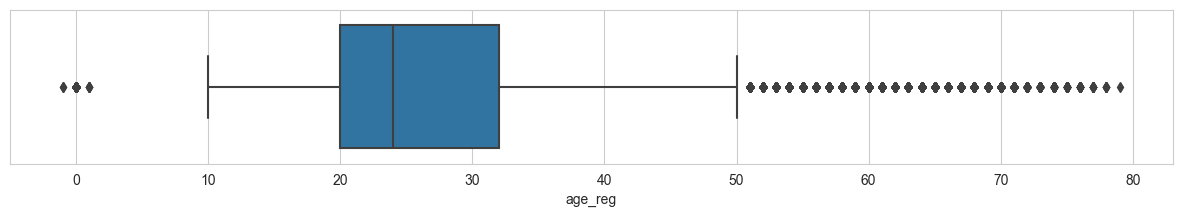

In [940]:
plt.figure(figsize=(15, 2))
sns.boxplot(data=teacher_info, x='age_reg');

Основную массу репетиторов составляют люди в возрасте до 50 лет. Медианное значение приходится на возраст 24 года. В данных есть и не корректные значения , плотность графика редее к показателю 100. Скорее всего есть в не точночти указания даты рождения с целью скрыть истинный возраст. 

In [34]:
print('Репетиторы млаже 14 лет: ', teacher_info[teacher_info.age_reg < 14]['age_reg'].count())
print('Репетиторы старше 50 лет: ', teacher_info[teacher_info.age_reg > 50]['age_reg'].count())

Репетиторы млаже 14 лет:  6802
Репетиторы старше 50 лет:  23083


Данные терять нельзя из-за не корректно заполненной даты. Посмотрим,есть ли данные репетиторы в нашей основной таблице с таргетом:

In [35]:
age_lst = ([int(x) for x in teacher_info[(teacher_info.age_reg < 14) | (teacher_info.age_reg > 90) ].index.tolist()])

In [36]:
sort_lst = []
for num in age_lst:
    if len(teachers.query('id == @num')) > 0 :
        sort_lst.append(num)
len(sort_lst)

22

22 индентификатора имеются в основной таблице, в дальнейшем думаю многие данные не потребуются по репетиторам. Пока что удалять не буду

In [37]:
(teacher_info.teaching_start_date - teacher_info.reg_date).dt.days/365

0        -18.326027
1         -4.317808
2        -19.326027
3         -1.315068
4         -3.983562
            ...    
307967   -24.202740
307968    -6.189041
307969    -1.186301
307970    -2.186301
307971    -0.186301
Length: 306813, dtype: float64

Колонка описанная как начало первого урока скорее подразумевает преподавательский стаж репетитора. Предлагаю из этой информации вычислить стаж репетитора на сегодняшний день.

In [38]:
teacher_info[['reg_date', 'teaching_start_date']].head(3)

,reg_date,teaching_start_date
0,2007-12-24 19:26:46+00:00,1989-09-01 00:00:00+00:00
1,2007-12-24 19:26:46+00:00,2003-09-01 00:00:00+00:00
2,2007-12-24 19:26:46+00:00,1988-09-01 00:00:00+00:00


In [941]:
teacher_info['experience_days'] = (teacher_info.Time.dt.date - teacher_info.teaching_start_date.dt.date).apply(lambda x: int(str(x).split(' ')[0]))

In [40]:
teacher_info.is_email_confirmed.nunique(), teacher_info.is_email_confirmed.unique()

(2, array([0, 1], dtype=int64))

Колонка с подтверждением email бинарная, в ней два значения, как и должно быть

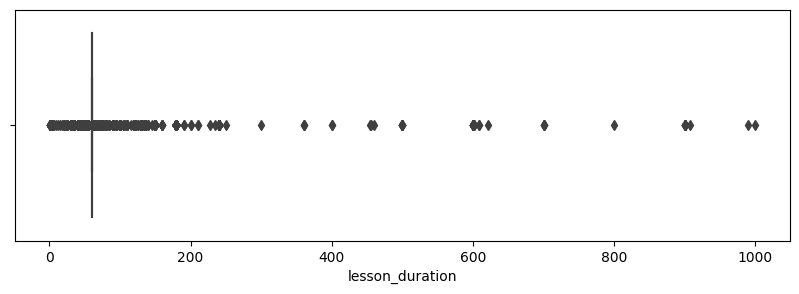

In [41]:
plt.figure(figsize=(10, 3))
sns.boxplot(data=teacher_info, x='lesson_duration');

In [42]:
teacher_info.lesson_duration.describe()

count    306813.000000
mean         61.456751
std          14.471870
min           1.000000
25%          60.000000
50%          60.000000
75%          60.000000
max         999.000000
Name: lesson_duration, dtype: float64

По колонке с информацией о длительности занятия мы видим, что минимальное значение равно одной минуте, возможно репетитор не понравился, или наоборот клиент чем-то не устроил. Основную часть по длительности занимают уроки в 60 минут.  Максимальное значение равно 999 что составляет более 16 часов, такие варианты возможно встречаются в реальности, но очень редко  и являются выбросами в данных.

In [43]:
print(teacher_info[teacher_info.lesson_duration > 190]['lesson_duration'].count())
teacher_info = teacher_info[teacher_info.lesson_duration < 190]

78


In [44]:
round(teacher_info.lesson_cost.describe())

count     306733.0
mean         532.0
std         2150.0
min            0.0
25%            0.0
50%          500.0
75%          900.0
max      1021709.0
Name: lesson_cost, dtype: float64

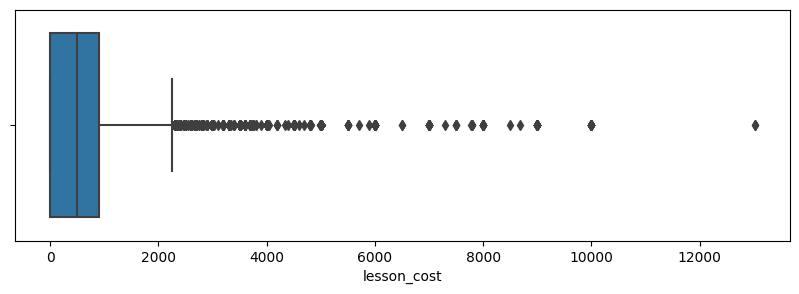

In [45]:
plt.figure(figsize=(10, 3))
sns.boxplot(data=teacher_info[teacher_info.lesson_cost < 15_000], x='lesson_cost');

Значения сильно редеют к отметке стоимости 6 тыс. Таких выбросов не много, предлагаю их убрать.

In [46]:
teacher_info[teacher_info.lesson_cost > 5_500]['lesson_cost'].count()

101

In [47]:
teacher_info = teacher_info[teacher_info.lesson_cost < 5_500]

In [48]:
print(teacher_info.is_display.nunique(), teacher_info.is_display.unique())
print(teacher_info.orders_allowed.nunique(), teacher_info.orders_allowed.unique())
print(teacher_info.is_cell_phone_confirmed.nunique(), teacher_info.is_cell_phone_confirmed.unique())


2 [1 0]
2 [0 1]
2 [0 1]


С информацией о показываемости репетитора, разрешением и подтверждением телефона всё хорошо, они бинарные, содержат корректные значения.

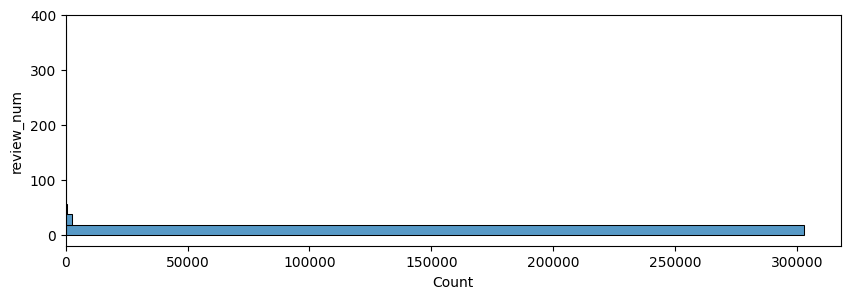

In [49]:
plt.figure(figsize=(10, 3))
sns.histplot(data=teacher_info, y='review_num');

In [50]:
teacher_info.review_num.value_counts().head(5)

review_num
0    252599
1     17792
2      8416
3      5248
4      3829
Name: count, dtype: int64

In [51]:
round(teacher_info.review_num.describe())

count    306625.0
mean          1.0
std           5.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max         381.0
Name: review_num, dtype: float64

Колонка с отзывами представлена количеством отзывов. Их или нет, или начинаются от 1-2 . Основное количество отзывов находится в диапазоне до 10, затем заметно количество их сокращается. 

In [52]:
print(teacher_info.area_id.nunique())
print(teacher_info.area_id.unique())
teacher_info.area_id.min(), teacher_info.area_id.max()

91
[  1  69   2  34  85  49  21  14  43  27  36  20  17  13  70  50  41   3
   5  25   4  23  45  15  35   6  62  11  44  12  16  58  32  55  39  30
  31  64  52  82  24  77   7  40  51  46  80  29  56  38   8   9  42  48
  22  18  10  33  54  53  19 120  37  59  63  60  57  61  47  66  81  68
  79  65  88  78  67  76  87  90  91   0 117  83  84  86  89 121 116 119
 118]


(0, 121)

В справочнике  [statdata.ru (Cтраны, города, статистика населения…)](https://www.statdata.ru/spisok-regionov-rossii-s-kodamy)  указано 89 региона. В наших же данных есть значения 119, 121... которые больше похожи на автомобильные коды регионов, где есть кодирование трёхзначными цифрами. Выбросов нет, с данныыми всё нормально. Единственно есть одно нулевое значение.

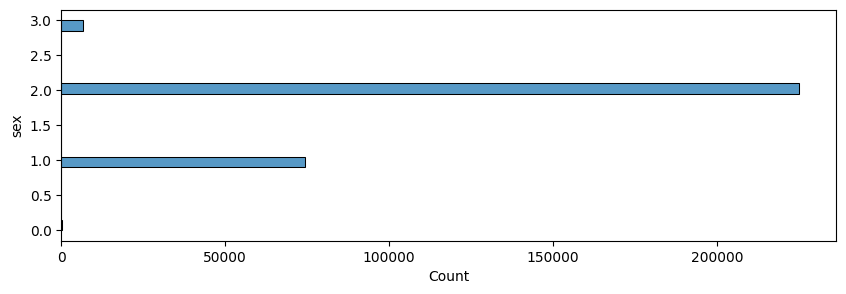

In [53]:
plt.figure(figsize=(10, 3))
sns.histplot(data=teacher_info, y='sex');

In [54]:
teacher_info.sex.value_counts()

sex
2    225204
1     74449
3      6758
0       214
Name: count, dtype: int64

Данный столбец трудно анализировать, предполагалось, что будут бинарные значения. Однако их 4. Значение 0, скорее всего говорит о не заполненности поля или не желание репетитора его заполнять (возможно это ведёт к плюсам (увеличению просмотров) в фильтрах поиска репетиторов. Значение 1 и 2 предполагаю, что меньшее количество репетиторов составляют женщины (75 тыс.) и большую (225 тыс.) мужчины. Значение "3" ...... Могу предположить, что это значение с выбором "иное".

После расчёта признаков на основе дат, предлагаю их теперь убрать.

In [55]:
teacher_info.drop(['reg_date', 'birth_date', 'teaching_start_date', 'last_visited', 'Time'], axis=1, inplace=True)
teacher_info.drop('orders_allowed', axis=1, inplace=True)

### Ученики (lesson_course.feather) <a id='3'></a>


In [56]:
lesson_course = pd.read_feather('lesson_course.feather')

In [57]:
lesson_course.head()

,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date
0,240884,427831.0,133738,718009.0,2,1000,1,60,2021-04-25 23:08:17.883,2018-08-27 00:00:00.000
1,242243,429075.0,106838,720876.0,1,0,0,0,2021-12-03 23:05:52.873,2020-08-01 00:00:00.000
2,242364,429089.0,14700,720912.0,1,0,0,0,2022-05-25 07:27:15.077,2019-09-08 14:22:41.940
3,242476,428940.0,138783,721219.0,1,0,0,0,2021-06-22 20:36:53.287,2018-09-03 00:00:00.000
4,242942,424704.0,3476,720891.0,4,600,0,60,2021-12-19 13:29:29.257,2022-03-20 00:00:00.000


In [58]:
lesson_course.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893438 entries, 0 to 893437
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 893438 non-null  int64  
 1   client_id          893437 non-null  float64
 2   teacher_id         893438 non-null  int64  
 3   order_id           890132 non-null  float64
 4   lesson_place       893438 non-null  int64  
 5   lesson_price       893438 non-null  int64  
 6   is_active          893438 non-null  int64  
 7   lesson_duration    893438 non-null  int64  
 8   date_updated       893438 non-null  object 
 9   suspend_till_date  893438 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 68.2+ MB


Аналогично, исправлю форматы данных:

In [59]:
lesson_course['client_id'] =  lesson_course['client_id'].dropna().astype('int')
lesson_course['order_id'] =  lesson_course['order_id'].dropna().astype('int')

In [60]:
lesson_course[lesson_course.select_dtypes(include=['object']).columns.tolist()].head()

,date_updated,suspend_till_date
0,2021-04-25 23:08:17.883,2018-08-27 00:00:00.000
1,2021-12-03 23:05:52.873,2020-08-01 00:00:00.000
2,2022-05-25 07:27:15.077,2019-09-08 14:22:41.940
3,2021-06-22 20:36:53.287,2018-09-03 00:00:00.000
4,2021-12-19 13:29:29.257,2022-03-20 00:00:00.000


In [61]:
lesson_course['suspend_till_date'] = pd.to_datetime(lesson_course['suspend_till_date']).dt.tz_localize('UTC')
lesson_course['date_updated'] = pd.to_datetime(lesson_course['date_updated']).dt.tz_localize('UTC')

In [62]:
print(lesson_course.loc[:, lesson_course.isnull().any()].isnull().sum())

pd.DataFrame(round(lesson_course.loc[:, lesson_course.isnull().any()].isnull().mean()*100,3)).style.background_gradient('coolwarm')

client_id       1
order_id     3306
dtype: int64


,0
client_id,0.000000
order_id,0.370000


Вданных есть один пропуск по индентификатору клиента и 3306 по 'order_id'

In [63]:
lesson_course[lesson_course.client_id.isnull() == True]

,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date
678496,882580,NaN,6249,287157.0,1,1200,0,60,2021-12-29 18:50:23.587000+00:00,1800-01-01 00:00:00+00:00


Думаю данный пропуск в колонке с индентификатором ученика можно удалить, так как одно значение с первого взгляда не исказит данные, но надо дополнительно просмотреть, важна ли данная информация для бизнеса

In [64]:
lesson_course[lesson_course.client_id.isnull() == True].merge(teachers, left_on='teacher_id', right_on='id')['teacher_id'].count()

0

Такого репетитора нет, который оказывал данный урок, удаляем строку

In [65]:
lesson_course = lesson_course.dropna(subset='client_id')

Посмотрим на уникальные значения в колонке 'lesson_duration' где у нас имеются пропуски в 'order_id':

In [66]:
lesson_course[lesson_course.order_id.isnull() == True]['lesson_duration'].unique()

array([0], dtype=int64)

Получается, что 'lesson_duration' имеет только нулевые значения, либо уроков не было, либо не проставлена их продолжительность

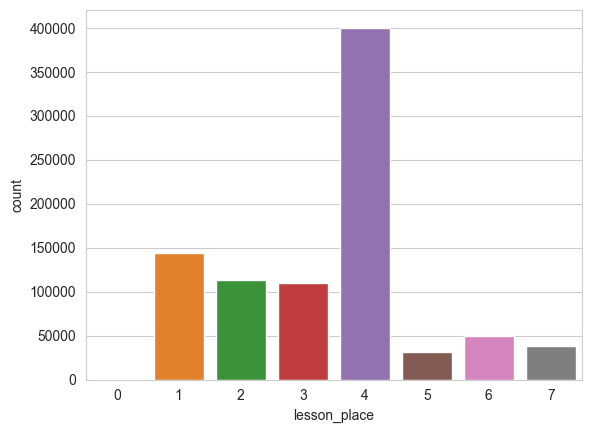

In [942]:
sns.countplot(data=lesson_course, x='lesson_place');

Предполагаю, что колонка которая в данных указана как lessin_place - заняти е онлайн или оффлайн должна быть бинарная, однако это не так и колонка содержит в себе значения от 0 до 7. Похоже на день недели проводимого занятия. 

In [69]:
lesson_course.query('order_id.isna()')['lesson_duration'].value_counts()

lesson_duration
0    3306
Name: count, dtype: int64

По всем наблюдениям где пропущен id заявки у нас продолжительность урока равна нулю. Т.е. заявка возможно не бралась, урока не было.

In [70]:
lesson_course = lesson_course.dropna()

In [943]:
lesson_course['client_id'] = lesson_course['client_id'].astype('int')
lesson_course['order_id'] = lesson_course['order_id'].astype('int')

Посмотрим на продолжительность уроков:

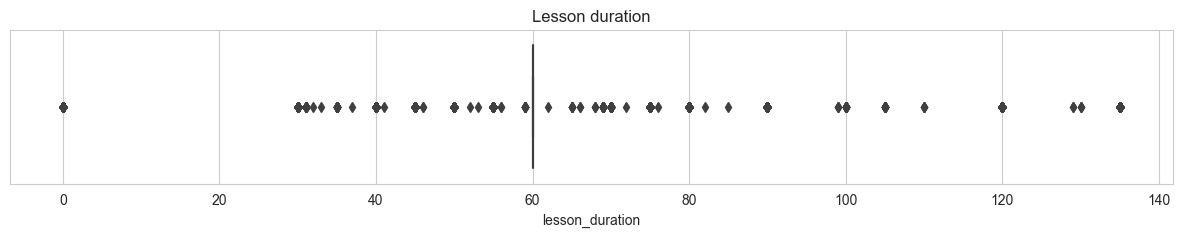

In [946]:
plt.figure(figsize=(15, 2))
sns.boxplot(data=lesson_course, x='lesson_duration')
plt.title('Lesson duration');

In [73]:
print('Years min: ', lesson_course.lesson_duration.min()/1440/365)
print('Years max: ', lesson_course.lesson_duration.max()/1440/365)

Years min:  -4085.775585996956
Years max:  15.281624809741249


В переводе в года, чтобы проще было анализировать, есть аномальные значения в продолжительности урока, как максимального  = 15 лет, так и отрицательного = 4085 лет.  

In [74]:
round(lesson_course.lesson_duration.describe())

count    8.901310e+05
mean    -4.755000e+03
std      3.218987e+06
min     -2.147484e+09
25%      6.000000e+01
50%      6.000000e+01
75%      6.000000e+01
max      8.032022e+06
Name: lesson_duration, dtype: float64

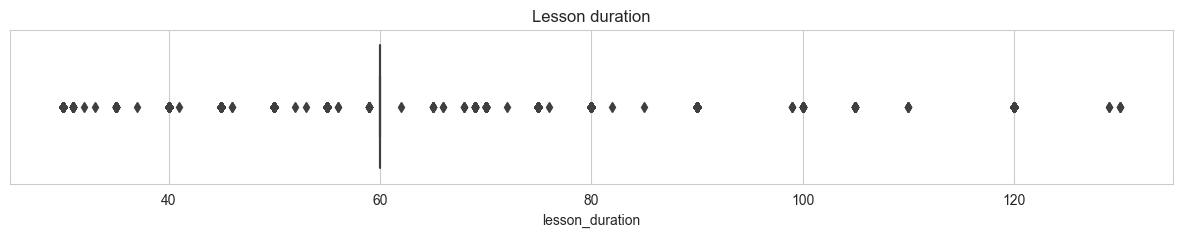

In [947]:
plt.figure(figsize=(15, 2))
sns.boxplot(data=lesson_course[(lesson_course.lesson_duration > 0) & (lesson_course.lesson_duration < lesson_course.lesson_duration.max())], x='lesson_duration')
plt.title('Lesson duration');

In [76]:
lesson_course = lesson_course[(lesson_course.lesson_duration >=0) & (lesson_course.lesson_duration < 4000)]

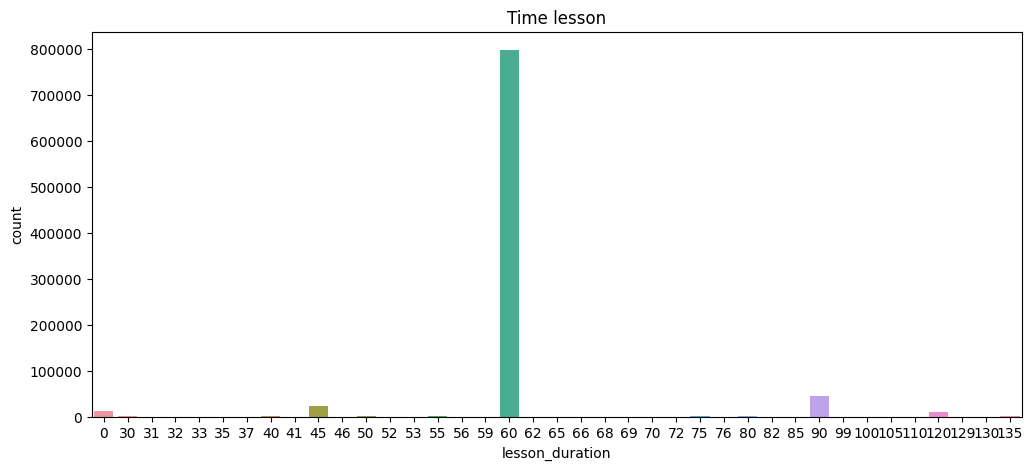

In [77]:
plt.figure(figsize=(12, 5))
sns.countplot(data=lesson_course[lesson_course.lesson_duration < 136], x='lesson_duration')
plt.title('Time lesson');

In [78]:
lesson_course.lesson_duration.value_counts().head(10)

lesson_duration
60     796974
90      43827
45      21953
0       12267
120     10255
30       1441
40        974
50        653
135       264
75        208
Name: count, dtype: int64

Основная продолжительность уроков лежит на промежутке от 0 до 135 минут, разбросаны не равномерно, в основном как видно из графика countplot, который группирует значения, занятия составляют 60 минут, или около 2 часов, остальные значения единичны, и искажают данные, уберу их.

In [79]:
lesson_course = lesson_course[lesson_course.lesson_duration < 136]

In [82]:
round(lesson_course.lesson_price.describe())

count     889526.0
mean        1289.0
std         3631.0
min            0.0
25%          700.0
50%         1000.0
75%         1500.0
max      2500000.0
Name: lesson_price, dtype: float64

Максимальная цена равняется 2,5 млн, что является выбросом

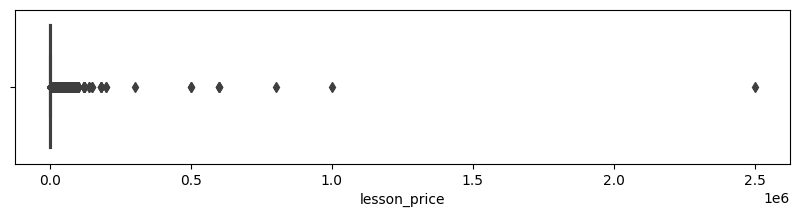

In [83]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=lesson_course, x='lesson_price');

Есть значения и в 1 млн, и более 200 тыс., сократим график на эти значения:

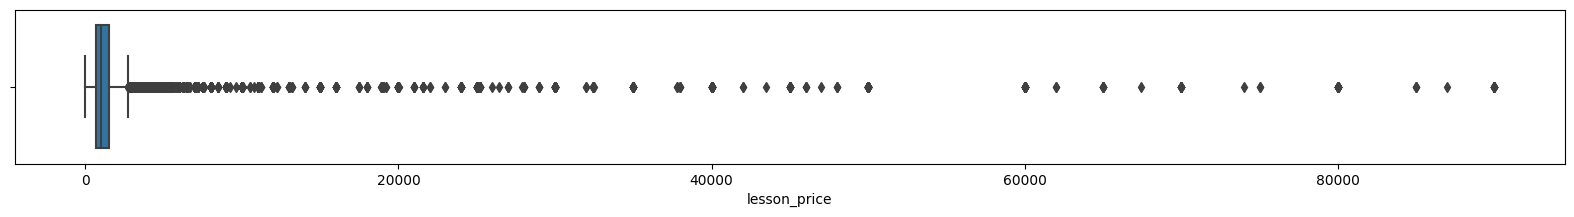

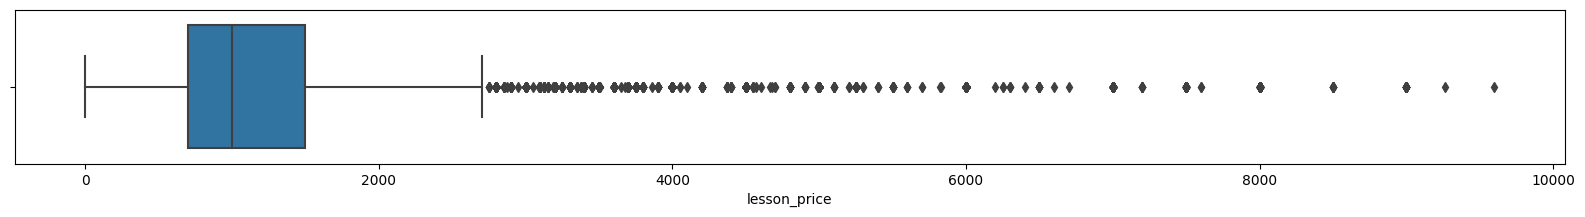

In [84]:
plt.figure(figsize=(20, 2))
sns.boxplot(data=lesson_course[lesson_course.lesson_price < 100_000], x='lesson_price')
plt.show()
plt.figure(figsize=(20, 2))
sns.boxplot(data=lesson_course[lesson_course.lesson_price < 10_000], x='lesson_price')
plt.show()


In [85]:
lesson_course[lesson_course.lesson_price > 10_000]['lesson_price'].count()

650

Уплотнение значений заканчивается отметкой в 6 тыс, далее значения редеют. Отбрасывать много значений на данном этапе (пока ещё не был произведён анализ признаков на таргет нет смысла), к тому же у меня нет точного прайса  с диапазонами цен на предметы, которые устанавливают репетиторы.

In [86]:
lesson_course = lesson_course[lesson_course.lesson_price < 10_001]

Очистила данные от пропусков в заявках. Минимально убрала выбросы в ценах и длительности уроков.

Информация с date_updated (дата обновления)  пока что нет мыслей, как эту информацию можно использовать. Клонка  suspend_till_date (приостановдение до указанной даты) возможно можно её по другому представить в данных, поясню: если дата начиная от сегодняшней превышает, то ставим 0(репетитор не принимает заявки) или 1(репетитор не приостановлен и работает),  логично предположить, что если репетитор не активный на данный момент, его и не сможет бизнес предложить в качестве альтернативного для клиента. Приостановление может быть связано с разными причинами(как со стороны бизнеса, так и по желанию преподавателя)

In [948]:
# Получение текущей даты
lesson_course['Time'] = pd.to_datetime(datetime.now())

In [88]:
(lesson_course.Time.dt.date - lesson_course.suspend_till_date.dt.date).apply(lambda x: 1 if int(str(x).split(' ')[0]) > 0 else 0).value_counts()

1    888776
0       100
Name: count, dtype: int64

Есть активные и приостановленные репетиторы, но данную информацию я думаю надо скорректировать по последней дате обновления,так как время идёт, и постоянно будет увеличиваться разница между этими колонками с датами, репетитор может быть не правильно отнесён к той или иной группе. В рассчитанном возрасте я оставила дату, та которая есть, так как там идёт целочисленное деление, без остатка.

In [949]:
lesson_course['Time'] = lesson_course['Time'] = pd.to_datetime(datetime.now())

In [950]:
lesson_course['activ_repetit'] = (lesson_course.Time.dt.date - lesson_course.suspend_till_date.dt.date).apply(lambda x: 1 if int(str(x).split(' ')[0]) > 0 else 0)

In [951]:
lesson_course.drop(['date_updated', 'suspend_till_date', 'Time'], axis=1, inplace=True)

In [93]:
lessons = pd.read_feather('lessons.feather')
lessons.head()

,id,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid
0,135797,347,2023-04-14 00:00:00.000,12:45:00,13:50:00,NaN,1,NaN,NaN
1,283596,185756,2022-11-15 00:00:00.000,20:30:00,21:30:00,NaN,0,NaN,NaN
2,322184,184189,2022-12-15 00:00:00.000,16:00:00,17:30:00,NaN,0,NaN,NaN
3,371621,213849,2023-02-13 00:00:00.000,19:30:00,20:30:00,NaN,0,NaN,NaN
4,375586,196475,2023-02-16 00:00:00.000,10:00:00,11:00:00,NaN,0,NaN,NaN


In [94]:
lessons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191127 entries, 0 to 1191126
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   id                1191127 non-null  int32   
 1   lesson_course_id  1191127 non-null  int32   
 2   lesson_date       1191127 non-null  category
 3   time_from         1191127 non-null  category
 4   time_to           1191127 non-null  category
 5   home_task         4969 non-null     category
 6   is_regular        1191127 non-null  int8    
 7   amount_to_pay     593376 non-null   float64 
 8   amount_paid       8143 non-null     float64 
dtypes: category(4), float64(2), int32(2), int8(1)
memory usage: 37.9 MB


Почти 1,2 млн занятий нам предоставили для анализа

In [95]:
print(lessons.loc[:, lessons.isnull().any()].isnull().sum())

pd.DataFrame(round(lessons.loc[:, lessons.isnull().any()].isnull().mean()*100,3)).style.background_gradient('coolwarm')

home_task        1186158
amount_to_pay     597751
amount_paid      1182984
dtype: int64


,0
home_task,99.583000
amount_to_pay,50.184000
amount_paid,99.316000


Колонки с информацией оплаты и выполнением домашнего задания почти пусты, имеют более 99% пропусков, удалю их. И нет половины данных с оплатой

In [96]:
lessons.drop(['home_task', 'amount_paid'], axis=1,  inplace=True)

In [97]:
lessons.amount_to_pay = lessons.amount_to_pay.dropna().astype('int')

In [98]:
lessons[lessons.select_dtypes(include=['category']).columns.tolist()].head()

,lesson_date,time_from,time_to
0,2023-04-14 00:00:00.000,12:45:00,13:50:00
1,2022-11-15 00:00:00.000,20:30:00,21:30:00
2,2022-12-15 00:00:00.000,16:00:00,17:30:00
3,2023-02-13 00:00:00.000,19:30:00,20:30:00
4,2023-02-16 00:00:00.000,10:00:00,11:00:00


In [99]:
lessons['lesson_date'] = pd.to_datetime(lessons['lesson_date']).dt.tz_localize('UTC').dt.tz_convert('Europe/Moscow')
lessons['time_from'] = pd.to_datetime(lessons['time_from']).dt.tz_localize('UTC').dt.tz_convert('Europe/Moscow')
lessons['time_to'] = pd.to_datetime(lessons['time_to']).dt.tz_localize('UTC').dt.tz_convert('Europe/Moscow')

C:\Users\smoly\AppData\Local\Temp\ipykernel_4248\695532048.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lessons['time_from'] = pd.to_datetime(lessons['time_from']).dt.tz_localize('UTC').dt.tz_convert('Europe/Moscow')
C:\Users\smoly\AppData\Local\Temp\ipykernel_4248\695532048.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lessons['time_to'] = pd.to_datetime(lessons['time_to']).dt.tz_localize('UTC').dt.tz_convert('Europe/Moscow')


In [100]:
lessons.head()

,id,lesson_course_id,lesson_date,time_from,time_to,is_regular,amount_to_pay
0,135797,347,2023-04-14 03:00:00+03:00,2024-03-27 15:45:00+03:00,2024-03-27 16:50:00+03:00,1,NaN
1,283596,185756,2022-11-15 03:00:00+03:00,2024-03-27 23:30:00+03:00,2024-03-28 00:30:00+03:00,0,NaN
2,322184,184189,2022-12-15 03:00:00+03:00,2024-03-27 19:00:00+03:00,2024-03-27 20:30:00+03:00,0,NaN
3,371621,213849,2023-02-13 03:00:00+03:00,2024-03-27 22:30:00+03:00,2024-03-27 23:30:00+03:00,0,NaN
4,375586,196475,2023-02-16 03:00:00+03:00,2024-03-27 13:00:00+03:00,2024-03-27 14:00:00+03:00,0,NaN


#### Обзор lessons

In [101]:
lessons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191127 entries, 0 to 1191126
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype                        
---  ------            --------------    -----                        
 0   id                1191127 non-null  int32                        
 1   lesson_course_id  1191127 non-null  int32                        
 2   lesson_date       1191127 non-null  datetime64[ns, Europe/Moscow]
 3   time_from         1191127 non-null  datetime64[ns, Europe/Moscow]
 4   time_to           1191127 non-null  datetime64[ns, Europe/Moscow]
 5   is_regular        1191127 non-null  int8                         
 6   amount_to_pay     593376 non-null   float64                      
dtypes: datetime64[ns, Europe/Moscow](3), float64(1), int32(2), int8(1)
memory usage: 46.6 MB


In [102]:
round(lessons['amount_to_pay'].describe())

count     593376.0
mean        1184.0
std         4685.0
min            0.0
25%          700.0
50%         1000.0
75%         1500.0
max      2500000.0
Name: amount_to_pay, dtype: float64

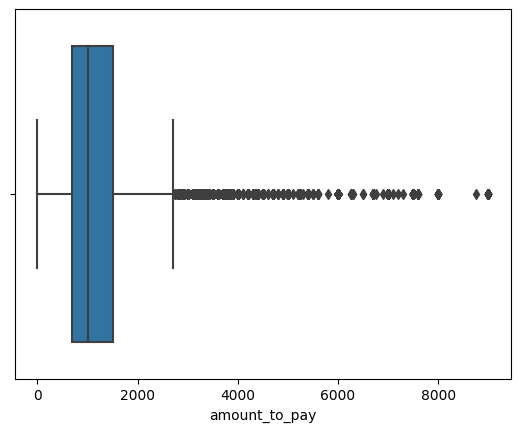

In [103]:
sns.boxplot(data=lessons[lessons.amount_to_pay < 10_000], x='amount_to_pay', orient='h');

Выбросы в оплаченных занятиях есть, максимальное значение составляет 2,5 млн. Возможно это ошибочное заполнение и их надо удалять, либо есть предположение о разности оплачиваемой валюты, всех подробностей у меня нет, данный нюанс надо уточнять у заказчика. Сейчас буду работать как с аномалиями.

In [104]:
print('Count > 40_000: ', lessons[lessons.amount_to_pay > 40_000]['amount_to_pay'].count())
print('Count > 30_000: ', lessons[lessons.amount_to_pay > 30_000]['amount_to_pay'].count())
print('Count > 20_000: ', lessons[lessons.amount_to_pay > 20_000]['amount_to_pay'].count())
print('Count > 10_000: ', lessons[lessons.amount_to_pay > 10_000]['amount_to_pay'].count())

print('MIN: ', lessons[lessons.amount_to_pay > 10_000].apply(lambda x: lessons[lessons.amount_to_pay > 10_000]['time_to'] - lessons[lessons.amount_to_pay > 10_000]['time_from'])['amount_to_pay'].min())
print('MAX: ', lessons[lessons.amount_to_pay > 10_000].apply(lambda x: lessons[lessons.amount_to_pay > 10_000]['time_to'] - lessons[lessons.amount_to_pay > 10_000]['time_from'])['amount_to_pay'].max())


Count > 40_000:  12
Count > 30_000:  31
Count > 20_000:  162
Count > 10_000:  253
MIN:  0 days 00:45:00
MAX:  0 days 06:00:00


Таких наблюдений не так и много. Не будем терять данные, заменим аномальные на медианные значения. И предлагаю, там где нет информации об оплате, т.е. бизнес не получил их, заполнить нулями.

In [105]:
lessons.loc[lessons.amount_to_pay.isnull(),  'amount_to_pay'] = lessons.amount_to_pay.fillna(0).astype('int')

In [106]:
lessons.loc[lessons.amount_to_pay > 10_000,  'amount_to_pay'] = lessons.amount_to_pay.median().astype('int')

In [107]:
date_time = (lessons['time_to'] - lessons['time_from']).dt.total_seconds()/60

In [108]:
print('MIN minutes lesson: ', ((lessons['time_to'] - lessons['time_from']).dt.total_seconds()/60).min())
print('MAX minutes lesson: ', ((lessons['time_to'] - lessons['time_from']).dt.total_seconds()/60).max())

MIN minutes lesson:  -1410.0
MAX minutes lesson:  1300.0


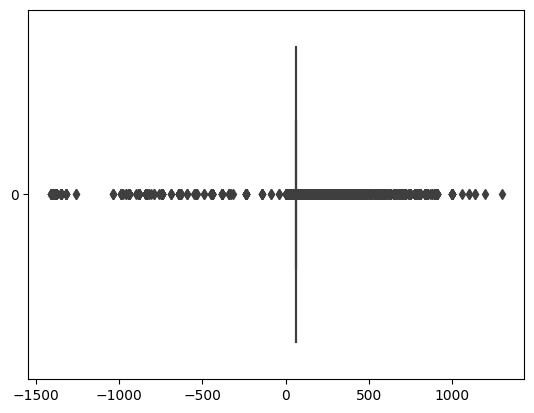

In [109]:
sns.boxplot(date_time.values, orient='h');

Отрицательных значений в продолжительности уроков быть не должно, есть два допустимых варианта, либо урок не проводился, либо он имеет положительное значение. Данные наблюдения очищаем.

In [110]:
print('Количество таких наблюдений: ', lessons[(lessons['time_to'] - lessons['time_from']).dt.total_seconds()/60 <= 0]['time_to'].count())

Количество таких наблюдений:  749


In [111]:
lessons['time_lesson_min'] = ((lessons['time_to'] - lessons['time_from']).dt.total_seconds()/60).astype('int')

Рассчитанная колонка с продoлжительностью урока в минутах нам понадобится в дальнейшем построении модели)

In [112]:
lessons = lessons[(lessons['time_to'] - lessons['time_from']).dt.total_seconds()/60 >= 0]

In [113]:
lessons.drop(['time_to', 'time_from'], axis=1, inplace=True)

### Цены на занятия репетиторов (teacher_prices.feather) <a id='5'></a>

In [114]:
teacher_prices = pd.read_feather('teacher_prices.feather')
teacher_prices.head()

,date_update,teacher_id,subject_id,price,price_external,price_remote
0,2008-01-20 19:47:18.587,300.0,2,1200,1200,1200
1,2008-01-22 00:33:39.660,125.0,13,0,0,3000
2,2008-01-22 00:33:39.660,125.0,14,0,0,3000
3,2008-01-22 00:37:01.963,91.0,8,2000,0,0
4,2008-02-08 21:27:19.177,372.0,33,400,400,400


In [115]:
teacher_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432422 entries, 0 to 432421
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date_update     432422 non-null  object 
 1   teacher_id      427852 non-null  float64
 2   subject_id      432422 non-null  int64  
 3   price           432422 non-null  int64  
 4   price_external  432422 non-null  int64  
 5   price_remote    432422 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 19.8+ MB


Индентификаторы не могут быть дробным числом, сделаем его целочисленным

In [116]:
teacher_prices['date_update'] = pd.to_datetime(teacher_prices['date_update']).dt.tz_localize('UTC')

In [117]:
teacher_prices.isnull().mean()

date_update       0.000000
teacher_id        0.010568
subject_id        0.000000
price             0.000000
price_external    0.000000
price_remote      0.000000
dtype: float64

Менее процента пропусков по индентификаторам

In [118]:
teacher_prices.groupby('teacher_id').agg({'subject_id': ['unique', 'nunique', 'count']})['subject_id'].sort_values(by=['nunique', 'count'], ascending=False).head(20)

,unique,nunique,count
teacher_id,,,
221263.0,"[2, 1, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 2...",17,17
184646.0,"[2, 23, 18, 29, 20, 27, 21, 1, 8, 10, 13, 14, ...",16,16
64189.0,"[1, 23, 8, 9, 10, 13, 12, 14, 15, 17, 2, 29, 1...",15,15
64190.0,"[1, 23, 8, 9, 10, 13, 12, 14, 15, 17, 2, 29, 1...",15,15
171269.0,"[8, 2, 7, 1, 9, 10, 11, 12, 13, 14, 15, 16, 29...",15,15
188258.0,"[2, 3, 4, 6, 7, 1, 8, 9, 10, 11, 12, 13, 14, 1...",15,15
87418.0,"[1, 19, 15, 2, 3, 11, 12, 13, 14, 29, 18, 27, ...",14,14
50379.0,"[2, 3, 4, 1, 5, 6, 7, 25, 23, 8, 9, 13, 15]",13,13
96935.0,"[2, 23, 3, 4, 7, 33, 1, 8, 9, 11, 29, 20, 21]",13,13


Мы видим, что есть преподаватели, которые либо ошибочно заполняют колонку с информацией об индентификаторе товара, либо провели по каждому предмету по одному уроку, что считаю не логичным, так как быть специалистом например в 17 предметах (если конечно они есть) невозможно, даже учителя начальных классов не имеют столько учебных дисциплин. К тому же числа уникальных значений и количество уроков совпадают, что только подтверждает неправильное заполнение информации 
P.s. есть теория, что преподаватели могут сами указывать все виды дисциплин, чтобы в заказы они также попадали при отборе кандидатов.

И будет ошибочно присвоить им какой-то один индентификатор предмета, потому как если преподаватель выбирается в зависимости от id-предмета и мы им присвоим не верный, данные могут искажаться. На первых порах предлагаю просмотреть данных репетиторов в таблице с таргетом.

In [119]:
teacher_del = teacher_prices.groupby('teacher_id').agg({'subject_id': ['unique', 'nunique', 'count']})['subject_id'].sort_values(by=['nunique', 'count'], ascending=False).head(18)

In [120]:
teacher_lst = [int(x) for x in teacher_del.index.tolist()]

In [121]:
for num in teacher_lst:
    if len(teachers.query('id == @num')) > 0 :
        display(teachers.query('id == @num'))

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
214,143227,2150,630.97,775,0.5882,19,489000,0


Из индентификаторов преподавателей только один имеет информацию в таблице с таргетом, поэтому предлагаю удалить данные строки. Почему я ограничилась числом 11  в данных, потому что считаю, что даже если индентификаторы предметов могли быть ошибочно записаны, это не исключает тот факт, что преподаватель может знать и преподавать например школьную математику для учеников 1-11 классов или смежные предметы, русский и литературу для учеников старших классов

In [122]:
teacher_lst = [x for x in teacher_del.index.tolist()]

Очистим данные от таких репетиторов:

In [123]:
teacher_prices = teacher_prices[~teacher_prices.teacher_id.isin(teacher_lst)]

Посмотрим на разброс значений в ценах на занятия:

In [124]:
#teacher_prices.groupby('teacher_id').agg({'subject_id': ['unique', 'nunique', 'count'], 'price': ['max', 'min', 'median'],\
#                                           'price_external': ['max', 'min', 'median'], 'price_remote': ['max', 'min', 'median']})

In [125]:
round(teacher_prices[['price',	'price_external',	'price_remote']].describe())

,price,price_external,price_remote
count,432177.0,432177.0,432177.0
mean,552.0,746.0,673.0
std,22981.0,28819.0,23038.0
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,400.0,600.0,500.0
75%,800.0,1000.0,1000.0
max,15045122.0,18824823.0,15045122.0


У многих не проставлена цена, даже 25-ый квантиль равен нулям, а это более 100 тысяч данных не имеют информацию. Также есть большие выбросы по всем ценах, от которых надо избавляться. Просмотрев небольшое количество репетиторов на данном сайте заказчика видно, что цены в 10 тыс. реальны за занятие, к тому же у преподователя есть отличный рейтинг и поэтому думаю отбросить все цены на урок свыше 15 тыс.

In [126]:
print('Таких наблюдений в данных: ', teacher_prices[teacher_prices.price > 10000]['price'].count(), 'шт.')
print('Таких наблюдений в данных: ', teacher_prices[teacher_prices.price_external > 10000]['price'].count(), 'шт.')
print('Таких наблюдений в данных: ', teacher_prices[teacher_prices.price_remote > 10000]['price'].count(), 'шт.')

Таких наблюдений в данных:  13 шт.
Таких наблюдений в данных:  12 шт.
Таких наблюдений в данных:  17 шт.


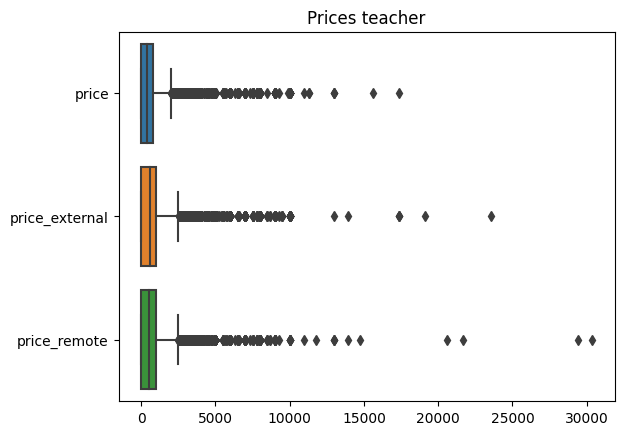

In [127]:
sns.boxplot(teacher_prices[['price', 'price_external', 'price_remote']][(teacher_prices.price < 50000) & (teacher_prices.price_external < 50000) & (teacher_prices.price_remote < 50000)], orient='h')
plt.title('Prices teacher');

In [128]:
teacher_prices = teacher_prices[(teacher_prices.price < 10001) & (teacher_prices.price_external < 10001) & (teacher_prices.price_remote < 10001)]

In [129]:
round(teacher_prices.describe())

,teacher_id,subject_id,price,price_external,price_remote
count,427587.0,432156.0,432156.0,432156.0,432156.0
mean,145916.0,10.0,512.0,693.0,630.0
std,89910.0,8.0,654.0,711.0,638.0
min,33.0,1.0,0.0,0.0,0.0
25%,67958.0,2.0,0.0,0.0,0.0
50%,139155.0,8.0,400.0,600.0,500.0
75%,220902.0,14.0,800.0,1000.0,1000.0
max,317929.0,36.0,10000.0,10000.0,9999.0


От выбросо визбавились,данные стали более устойчивы. 

In [130]:
print(teacher_prices.loc[:, teacher_prices.isnull().any()].isnull().sum()*100)
teacher_prices.loc[:, teacher_prices.isnull().any()].isnull().mean()*100

teacher_id    456900
dtype: int64


teacher_id    1.057257
dtype: float64

В данной таблице около процента пропусков по индентификаторам репетиторов, предлагаю удалить эти данные, так как мы не можем их восстановить, потому что таблица не содержит таких данных, которые мы смогли бы использовать.

In [131]:
teacher_prices = teacher_prices.dropna()

In [132]:
teacher_prices['teacher_id'] = teacher_prices['teacher_id'].astype('int')

приступим к следующей таблице

### Заявки (orders.feather) <a id='6'></a>

In [953]:
orders = pd.read_feather('orders.feather')
orders.head()

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,None,NaN,None,None,NaN,16,None,NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,None,NaN,None,None,NaN,7,"\n01.11.2022 11:46 - ""Заявка прикреплена к зая...",NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 10:37:02.567,143480.0,16,None,NaN,0,7,None,NaN,14.0,2,0,3,0,0,4,0,0,0,0,0,23,NaN,1024439,10.0,NaN,1200,None,1
3,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 00:08:47.437,236392.0,16,None,NaN,0,10,None,47749.0,10.0,3,0,3,5,0,4,0,20,90,0,0,14,2293804.0,1024340,17.0,NaN,2310,None,1
4,2294058,2022-11-01 00:11:49.417,8.0,None,0,60,None,122.0,None,None,NaN,16,Тестовая группа : SplitTestA,NaN,0,0,None,NaN,NaN,0,0,0,0,0,2,0,0,0,0,0,16,NaN,1024440,5.0,NaN,None,None,1


In [954]:
print(orders.loc[:, orders.isnull().any()].isnull().sum())

pd.DataFrame(round(orders.loc[:, orders.isnull().any()].isnull().mean()*100,3)).style.background_gradient('coolwarm')

subject_id                 10332
purpose                   166510
lesson_place             1191830
home_metro_id             549414
add_info                  147173
start_date                486283
working_teacher_id        485873
comments                  850393
prefered_teacher_id      1191857
first_lesson_date        1025290
creator_id                612163
pupil_category_new_id     159391
original_order_id         609273
additional_status_id      149476
max_metro_distance       1178343
estimated_fee             444709
payment_date             1062196
dtype: int64


,0
subject_id,0.867000
purpose,13.971000
lesson_place,99.997000
home_metro_id,46.097000
add_info,12.348000
start_date,40.800000
working_teacher_id,40.766000
comments,71.350000
prefered_teacher_id,100.000000
first_lesson_date,86.024000


Где более 60% пропусков, удалю сразу:

In [955]:
orders.drop(orders.loc[:, orders.isnull().mean() > 0.98].columns.tolist(), axis=1, inplace=True)

In [957]:
print('Количество дубликатов: ', orders.duplicated().sum())
orders = orders.drop_duplicates()

Количество дубликатов:  0


В колонке original_order_id содержится информация о дублях заявок, найдём их:

In [958]:
print('Количество дубликатов составило: ', orders[orders.id == orders.original_order_id]['original_order_id'].count())

Количество дубликатов составило:  851


In [959]:
orders[orders.select_dtypes(include=['object']).columns.tolist()].sample(5)

,order_date,purpose,add_info,start_date,comments,amount_to_pay,first_lesson_date,estimated_fee,payment_date
61605,2022-01-01 18:41:28.987,None,None,None,"\n02.01.2022 12:18 - ""Заявка прикреплена к зая...",0,None,None,None
286062,2023-10-10 16:35:55.500,Дополнения: подготовка к олимпиадам.\nКатегори...,Место проведения занятий: дистанционно (наприм...,2023-10-10 17:09:47.077,None,0,None,2205,None
216907,2023-09-17 20:32:00.130,Дополнения: ЕГЭ.\nКатегория ученика: 11 класс....,Желаемое время для занятий: понедельник - 17; ...,None,Тестовая группа : SplitTestA,0,None,None,None
95365,2021-10-28 17:26:24.057,Разделы: школьный курс.\nКатегория ученика: у...,Место проведения занятий: дистанционно (предпо...,2021-10-28 17:26:42.153,None,0,None,4030,None
97730,2023-07-30 04:53:58.097,Разделы: школьный курс.\nКатегория ученика: д...,Район: м. Нагорная.\nМесто проведения занятий:...,2023-07-30 13:08:20.433,None,0,None,8500,None


In [960]:
orders['order_date'] = pd.to_datetime(orders['order_date'], errors = 'coerce').dt.tz_localize('UTC')
orders['start_date'] = pd.to_datetime(orders['start_date'], errors = 'coerce').dt.tz_localize('UTC')
orders['first_lesson_date'] = pd.to_datetime(orders['first_lesson_date'], errors = 'coerce').dt.tz_localize('UTC')
orders['payment_date'] = pd.to_datetime(orders['payment_date'], errors = 'coerce').dt.tz_localize('UTC')

Изменим тип у колонки с суммой оплаты:

In [961]:
orders.amount_to_pay = orders.amount_to_pay.apply(lambda x: round(float(x.replace(',', '.'))))

И предполагаемом вознаграждении:

In [962]:
orders.estimated_fee = orders.estimated_fee.fillna('0').apply(lambda x: round(float(x.replace(',', '.'))))

In [963]:
print(orders.chosen_teachers_only.unique(), orders.chosen_teachers_only.value_counts())
print(orders.is_display_to_teachers.unique(), orders.is_display_to_teachers.value_counts())
print(orders.no_teachers_available.unique(), orders.no_teachers_available.value_counts())
orders[['chosen_teachers_only', 'is_display_to_teachers', 'no_teachers_available']].isnull().sum()

[0 1] chosen_teachers_only
0    1164322
1      26639
Name: count, dtype: int64
[1 0] is_display_to_teachers
1    1148256
0      42705
Name: count, dtype: int64
[0 1] no_teachers_available
0    1082753
1     108208
Name: count, dtype: int64


chosen_teachers_only      0
is_display_to_teachers    0
no_teachers_available     0
dtype: int64

В данной таблице достаточно данных, чтобы анализировать признаки отдельно от основной таблицы с таргетом, потому что восстановить будет намного легче и данные будут более корректные. Поэтому и выбран вариант рассмотреть, каждую таблицу в отдельности, изучить данные, затем уже приступить к отбору признаков. Возможно много данных не потребуется.

In [964]:
orders[orders.order_date.isnull()]

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,estimated_fee,payment_date,is_display_to_teachers
105390,3211265,NaT,3211265.0,None,3211265,3211265,3211265.0,None,NaT,3211265.0,3211265,None,0,3211265,NaT,3211265.0,3211265.0,3211265,3211265,3211265,3211265,3211265,3211265,3211265,3211265,3211265,1,1,3211265,3211265.0,3211265,3211265.0,0,NaT,1
109392,3342337,NaT,3342337.0,None,3342337,3342337,3342337.0,None,NaT,3342337.0,3342337,None,0,3342337,NaT,3342337.0,3342337.0,3342337,3342337,3342337,3342337,3342337,3342337,3342337,3342337,3342337,1,1,3342337,3342337.0,3342337,3342337.0,0,NaT,1
437216,3605505,NaT,3605505.0,None,3605505,3605505,3605505.0,None,NaT,3605505.0,3605505,None,0,3605505,NaT,3605505.0,3605505.0,3605505,3605505,3605505,3605505,3605505,3605505,3605505,3605505,3605505,1,1,3605505,3605505.0,3605505,3605505.0,0,NaT,1


По пропускам в колонке с номером заявки отмечено, что на заявку нет подходящих репетиторов и многие данныене кореектны(например с указанием стажа и желаемого возраста, которые представлены семизначными числами), такая информация нам не нужна.

In [965]:
orders = orders.dropna(subset=['order_date'])

In [966]:
orders.subject_id.unique()

array([ 1., 21.,  8.,  3.,  9., 33.,  5.,  2., 18., 27., 10., 15., 11.,
        6., 13., 14., 12., 36., 19., 17.,  7., nan, 20., 25.,  4., 29.,
       23., 16.], dtype=float32)

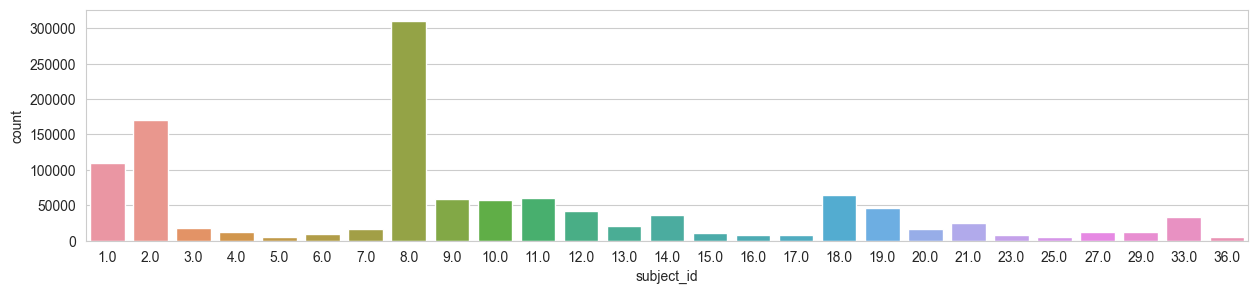

In [967]:
plt.figure(figsize=(15, 3))
sns.countplot(data=orders, x='subject_id');

Самые популярные предметы с кодами 8, 1 и 2. Всего в списке 27 предметов, пропусков около процента, и заполнение модой считаю оптимальным вариантом.

In [968]:
orders.loc[orders['subject_id'].isnull(), 'subject_id'] = orders['subject_id'].dropna().mode().values[0]

In [969]:
orders['subject_id'] = orders['subject_id'].astype('int')

In [970]:
orders.purpose.value_counts()

purpose
Разделы:  школьный курс.\nДополнения: ОГЭ (ГИА).\nКатегория ученика: школьник 9 класса.\nЦель занятий: подготовка к ОГЭ.                                                                                                            11443
Дополнения: ОГЭ (ГИА).\nКатегория ученика: 9 класс.\nДо экзамена осталось: Несколько месяцев.\n                                                                                                                                     10586
Разделы:  школьный курс.\nДополнения: ЕГЭ.\nКатегория ученика: школьник 11 класса.\nЦель занятий: подготовка к ЕГЭ.                                                                                                                  9757
Цели: помощь по школьной программе.\nКатегория ученика: 8 класс.\n                                                                                                                                                                   5678
Дополнения: ОГЭ (ГИА).\nКатегория ученика: 9 класс.\nДо 

In [971]:
orders.purpose.dropna().apply(lambda x: str(x).split('.')[0].split(':')[-1].strip()).value_counts()

purpose
школьный курс                                                                                                                                        318670
общий курс                                                                                                                                           123756
ЕГЭ                                                                                                                                                   63211
ОГЭ (ГИА)                                                                                                                                             42444
помощь по школьной программе                                                                                                                          42399
                                                                                                                                                      ...  
бокс, боевые искусства, легкая атлетика, гимнастика, рук

Информация о целях занятия сильно разная, в группы её не объединить, но возможно чуть сократить записи и тем самым сделать более группируемыми с помощью вытягивания слов после слов: "Раздел". 

In [972]:
orders['purpose'] = orders.purpose.apply(lambda x: str(x).split('.')[0].split(':')[-1].strip())

In [973]:
orders.loc[orders['purpose'] == "None", 'purpose'] = orders['purpose'].mode()[0]

In [974]:
round(orders.lesson_price.max())

1000000000

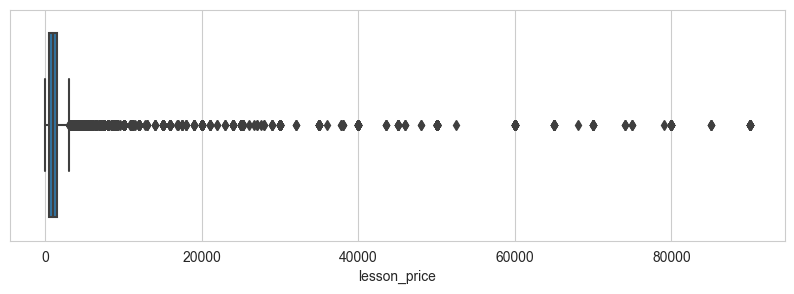

In [975]:
plt.figure(figsize=(10, 3))
sns.boxplot(data=orders[orders.lesson_price < 100_000], x='lesson_price');

In [976]:
orders[orders.lesson_price > 35_000].lesson_price.count()

350

Выбросы есть по каждой числовой колонке, я их стараюсь смотреть и удалять, но удаление этих данных может и повлиять на качество предсказания, есть мысль, что потом, чтобы качество предсказания не снижать, если будут встречаться через чур высокие числовые значения то их следует заполнять предположим медианными исходя их других признаков. Например если мы говорим про цену, то заполнение или замена значения будут идти в группировке по предмету + длительности предполагаемого занятия + стаж репетитора (либо плюсом будет количество положительных отзывов). Признаков можно отобрать много для регулирования таких аномалий, смотря какие данные бизнес предоставит. 

In [161]:
orders = orders[orders.lesson_price < 35_000]

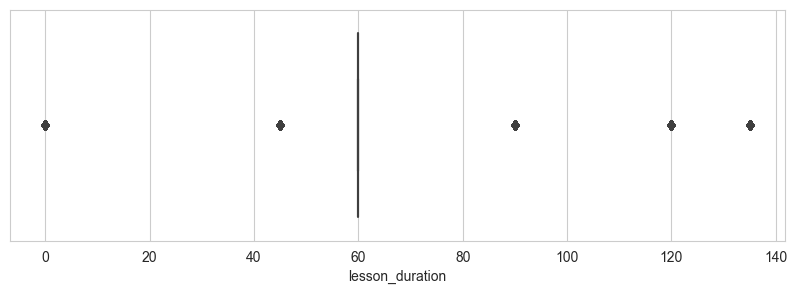

In [977]:
plt.figure(figsize=(10, 3))
sns.boxplot(data=orders, x='lesson_duration');

In [163]:
round(orders.lesson_duration.describe())

count    1190583.0
mean          61.0
std            7.0
min            0.0
25%           60.0
50%           60.0
75%           60.0
max          135.0
Name: lesson_duration, dtype: float64

In [164]:
orders['lesson_duration'] = orders.lesson_duration.astype('int')

Здесь всё в норме, в основном заказчики указывают стандартную продолжительность (60 минут) урока, есть и те которые либо не указали продолжительность (возможно этот пункт они хотят обговорить с репетитором индивидуально) или желают заниматься около 2 часов.

-----

In [165]:
orders.add_info.apply(lambda x: str(x).strip().split('Место проведения занятий: ')[-1].split('(')[0]).value_counts().head(7)

add_info
дистанционно                                                                                   289072
у ученика                                                                                      262795
None                                                                                           147095
у преподавателя                                                                                130800
Количество занятий в неделю: 1-2.\nВозраст репетитора: не важно.\nПол репетитора: Не важно.      7316
Подстроюсь под репетитора                                                                        7129
​Место проведения занятий : у ученика                                                            6129
Name: count, dtype: int64

Эту информацию будет сложнова-то отфильтровать, чтобы оставить интересующую информацию. Пока что её не трогаем

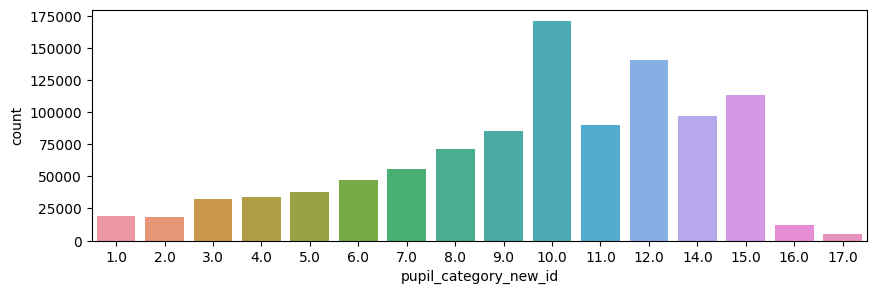

In [166]:
plt.figure(figsize=(10, 3))
sns.countplot(data=orders, x='pupil_category_new_id');

В основном обращаются за услугами репетиторов для обучения детей в возрасте от 10-15 лет (старшие классы). По данным около 13% пропусков, можно заполнить модой.

In [167]:
orders.loc[orders.pupil_category_new_id.isnull(), 'pupil_category_new_id'] = orders.pupil_category_new_id.mode()[0]

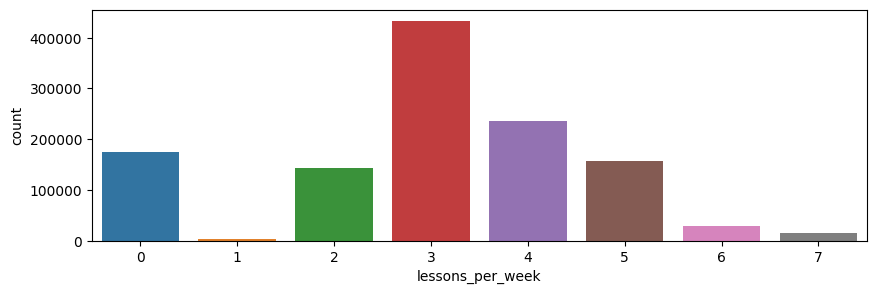

In [168]:
plt.figure(figsize=(10, 3))
sns.countplot(data=orders, x='lessons_per_week');

Более актуальны для заказчиков более интенсивные занятия в неделю, 3-5. Некоторые не указывают(возможно хотят обсудить при встрече с репетитором), значения нормальные и корректны.

Колонку с комментариями рассматривать не будем в ней около 70 % пропусков также колонки не рассмотрим first_lesson_date и payment_date

In [170]:
orders.source_id.unique() 

array([18, 23, 14, 16,  8, 17, 24,  2,  5,  4,  6, 13,  9,  7, 22, 12,  3,
       26,  0, 25, 11, 20])

In [171]:
round(orders[['teacher_age_to', 'teacher_age_from', 'teacher_sex', 'teacher_experience_from', 'teacher_experience_to','lesson_place_new', 'minimal_price', 'pupil_knowledgelvl', 'status_id']].describe())

,teacher_age_to,teacher_age_from,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,minimal_price,pupil_knowledgelvl,status_id
count,1190583.0,1190583.0,1190583.0,1190583.0,1190583.0,1190583.0,1190583.0,1190583.0,1190583.0
mean,17.0,8.0,2.0,1.0,1.0,3.0,186.0,0.0,13.0
std,100.0,13.0,1.0,3.0,8.0,2.0,1062.0,1.0,4.0
min,-110.0,-40.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
25%,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,7.0
50%,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,16.0
75%,40.0,20.0,3.0,1.0,0.0,4.0,0.0,0.0,16.0
max,99999.0,4016.0,3.0,51.0,500.0,7.0,1000000.0,4.0,16.0


Заполню отрицательные и не реальные значения возраста на наиболее частую:

In [172]:
orders.loc[(orders.teacher_age_from > 80) | (orders.teacher_age_from <= 0), 'teacher_age_from'] = orders.teacher_age_from.mode()[0]
orders.loc[(orders.teacher_age_to > 80) | (orders.teacher_age_to <= 0), 'teacher_age_to'] = orders.teacher_age_to.mode()[0]

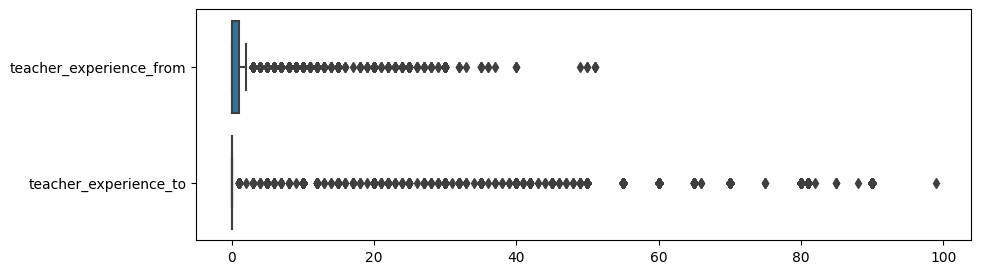

In [173]:
plt.figure(figsize=(10, 3))
sns.boxplot(data=orders[orders.teacher_experience_to < 100][['teacher_experience_from', 'teacher_experience_to']], orient='h');

In [174]:
orders[orders.teacher_experience_to > 60]['teacher_experience_to'].count()

8176

стаж работы оставляем до 55 лет (не реально конечно) если считать, что на момент получения хоть какого-либо образования составляет минимум 20 лет + не реальный стаж 55, если конечно репетитор способен преподавать в таком возрасте .

In [175]:
orders.loc[orders.teacher_experience_to > 55, 'teacher_experience_to'] = orders.teacher_experience_to.mode()[0]

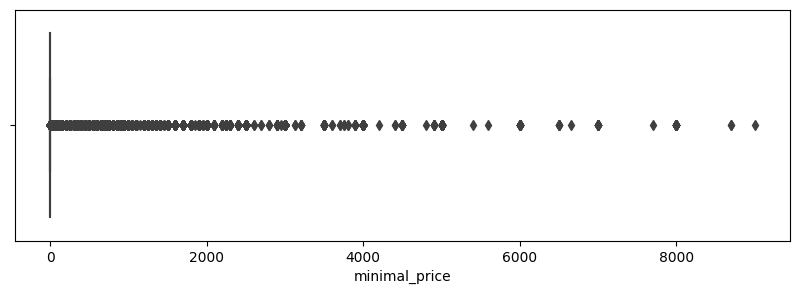

In [176]:
plt.figure(figsize=(10, 3))
sns.boxplot(data=orders[orders.minimal_price < 10_000], x='minimal_price', orient='h');

In [177]:
print(orders[orders.minimal_price > 10_000]['minimal_price'].count())
print(orders[orders.minimal_price > 5_000]['minimal_price'].count())

111
202


На самом деле не так много заявок,  где цена поставлена свыше 5 тыс., в большинстве случаев она не указана

In [178]:
orders.loc[orders.minimal_price > 5_000, 'minimal_price'] = orders[orders.minimal_price < 5_000]['minimal_price'].median()

In [179]:
orders.pupil_knowledgelvl.value_counts()

pupil_knowledgelvl
0    946427
2    105348
1     85274
3     46810
4      6724
Name: count, dtype: int64

Думаю уровень ученика оценивается по пятибальной системе (значений с отметкой 5 нет, такие люди оценивающие себя на отлично в репетиторе не нуждаются)

---

Информация в колонке status_id - оплачена ли заявка представленная кодами, где заказчик уточнил, что код 6 и 13 это факт оплаты. Предлагаю колонку перевести в бинарную. Код 6 и 13 в 1, остальные значения приравнять к 0.

In [180]:
orders.loc[(orders.status_id == 6) | (orders.status_id == 13), 'status_id'] = 1
orders.loc[orders.status_id != 1, 'status_id'] = 0

---

In [181]:
(orders.first_lesson_date.dt.date - orders.start_date.dt.date).dropna().value_counts()

1 days      23488
2 days      23052
3 days      19829
4 days      17122
5 days      14439
            ...  
235 days        1
218 days        1
219 days        1
128 days        1
345 days        1
Name: count, Length: 253, dtype: int64

In [182]:
orders.drop(['first_lesson_date', 'payment_date'], axis=1, inplace=True)

Можно было бы рассчитать такой признак, как количество дней, которое прошло от момента заявки на репетитора до фактически проведённого урока, но данных по этим колонкам мало, и на выходе чуть больше 250 записей, смысла в этой фиче нет

---

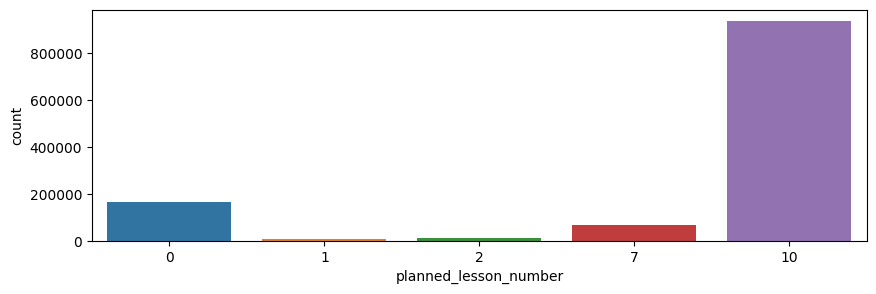

In [183]:
plt.figure(figsize=(10, 3))
sns.countplot(data=orders, x='planned_lesson_number');

In [184]:
orders.planned_lesson_number.value_counts()

planned_lesson_number
10    937625
0     166468
7      68298
2      11622
1       6570
Name: count, dtype: int64

В основном планируют около 10 занятий или вовсе не указывают.

---

И на последок осталась колонка с предполагаемым вознаграждением, посмотрим на значения:

In [185]:
orders.estimated_fee.value_counts()

estimated_fee
0        501988
5250      23964
2250      22957
1500      19208
1350      13600
          ...  
16415         1
3488          1
5038          1
1802          1
4785          1
Name: count, Length: 1496, dtype: int64

In [186]:
round(orders.estimated_fee.describe())

count    1190583.0
mean        2013.0
std         2701.0
min            0.0
25%            0.0
50%         1395.0
75%         3150.0
max       175000.0
Name: estimated_fee, dtype: float64

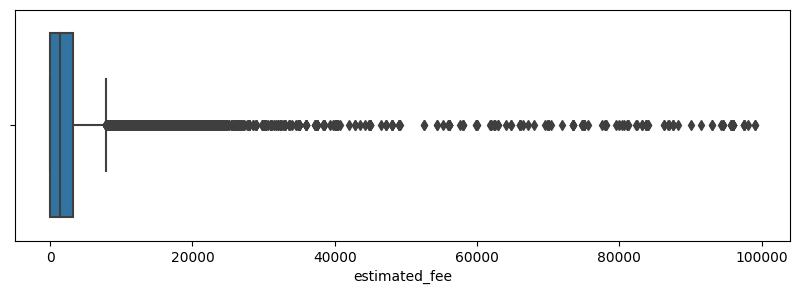

In [187]:
plt.figure(figsize=(10, 3))
sns.boxplot(data=orders[orders.estimated_fee < 100_000], x='estimated_fee', orient='h');

In [188]:
print(orders[orders.estimated_fee > 10_000]['planned_lesson_number'].unique())
pd.DataFrame(orders[orders.estimated_fee > 10_000][['estimated_fee', 'planned_lesson_number', 'lesson_price']].describe())

[10  7]


,estimated_fee,planned_lesson_number,lesson_price
count,15485.000000,15485.000000,15485.000000
mean,14667.548143,9.982564,4822.268195
std,7277.917486,0.228053,2469.814152
min,10050.000000,7.000000,0.000000
25%,11250.000000,10.000000,4000.000000
50%,14000.000000,10.000000,5000.000000
75%,16000.000000,10.000000,5000.000000
max,175000.000000,10.000000,32000.000000


In [189]:
orders[orders.estimated_fee < 10_000][['estimated_fee', 'planned_lesson_number', 'lesson_price']].apply(lambda x: orders.estimated_fee / ((orders.lesson_price / 100) * orders.planned_lesson_number))['estimated_fee'].dropna().value_counts()

estimated_fee
0.000000      319359
35.000000      79482
15.000000      52716
21.428571      38379
30.000000      31287
               ...  
13.333333          1
36.600000          1
210.000000         1
22.040000          1
12.300000          1
Name: count, Length: 1135, dtype: int64

Значения с гонораром более 10 тыс. имеют в заявке более 7 (7 и 10) занятий с репетитором. Описание столбца заказчик не предоставил, но если рассчитать его путём нахождения процента от стоимости планируемых уроков, то становится похоже (может и ошибаюсь) что это процент(комиссия) заказчика за предоставление своих услуг по подбору репетиторов. Также если отталкиваться, что урок может стоить до 32 тыс. как в описательных статистиках выше, то всё равно в колонке есть выбросы, которые мы рассчитаем из формуле выше, возьмём за основу значение между первыми чаще встречаемыми процентами, примерно 25.

In [190]:
orders.loc[orders.estimated_fee > 10_000, 'estimated_fee']

204       14000
213       10500
235       11750
574       15500
815       13500
          ...  
436830    15500
436861    10500
436952    17600
436956    14000
437015    15500
Name: estimated_fee, Length: 15485, dtype: int64

In [191]:
mask = (orders.estimated_fee > 10_000)
orders.loc[mask, 'estimated_fee'] = ((orders.loc[mask, 'lesson_price'] / 100) * orders.loc[mask, 'planned_lesson_number']) * 25
orders.drop('working_teacher_id', axis=1, inplace=True)

Приступим к работе  с основной таблицей, содержащей таргет.

### Отбор признаков <a id='7'></a>

Соединим данные по ученикам, какие курсы проходили и иную информацию:

In [470]:
lessons.shape, lesson_course.shape

((1190378, 6), (888876, 9))

In [471]:
lesson_client_all = pd.merge(lessons[['id',	'lesson_course_id',	'is_regular',	'amount_to_pay',	'time_lesson_min']], lesson_course, left_on='lesson_course_id', right_on='id', suffixes=('_lessons', '_lesson_course'))
lesson_client_all.head()

,id_lessons,lesson_course_id,is_regular,amount_to_pay,time_lesson_min,id_lesson_course,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,activ_repetit
0,135797,347,1,0.0,65,347,227275,33,11,3,1500,0,50,1
1,3545863,347,0,500.0,60,347,227275,33,11,3,1500,0,50,1
2,3545925,347,0,250.0,60,347,227275,33,11,3,1500,0,50,1
3,3582646,347,0,1500.0,90,347,227275,33,11,3,1500,0,50,1
4,482750,179311,0,0.0,90,179311,380741,24123,613191,1,2000,1,0,1


In [472]:
lesson_client_all.shape

(1047564, 14)

Соединим основную таблицу с таргетом и информацию по репетиторам. Соединяем с помощью inner соединения, исключая тех репетиторов, по которым у нас нет информации, так как если в дальнейшем окажется, что признаки из анкеты нам важны, мы не сможем обрабатывать репетиторов безинформации. Либо бизнесу надо сделать обязательную регистрацию репетиторов, проверку на корректность заполнения полей при регистрации (установить ограничение по вводу предположим возраст должен быть двухзначным числом и т.д.) это на мой взгляд, более полные и корректные значения  дадут буст для разработанной модели предсказания.

In [662]:
lesson_group_teacher = lesson_client_all.groupby('teacher_id').agg({'amount_to_pay': 'sum', 'lesson_price':   lambda x: x.mode()[0], 'time_lesson_min': ['mean', 'min', 'max'], \
                                                            'activ_repetit':  lambda x: x.mode()[0], 'is_regular': 'max', 'lesson_place':  lambda x: x.mode()[0], 'is_active':  lambda x: x.mode()[0], 'lesson_duration': 'mean'}).reset_index()


In [664]:
lesson_group_teacher.columns = [''.join(col) if i == 0 else '_'.join(col) for i, col in enumerate(lesson_group_teacher.columns)]
lesson_group_teacher = lesson_group_teacher.rename(columns={
    ('lesson_price_<lambda>'): 'lesson_price_name_mode',
    ('activ_repetit_<lambda>'): 'activ_repetit_name_mode',
    ('lesson_place_<lambda>'): 'lesson_place_name_mode',
    ('is_active_<lambda>'): 'is_active_name_mode'
})
lesson_group_teacher.head()

,teacher_id,amount_to_pay_sum,lesson_price_name_mode,time_lesson_min_mean,time_lesson_min_min,time_lesson_min_max,activ_repetit_name_mode,is_regular_max,lesson_place_name_mode,is_active_name_mode,lesson_duration_mean
0,33,301590.0,1000,61.642447,45,240,1,1,0,1,63.652008
1,86,1000.0,1000,60.000000,60,60,1,0,3,0,60.000000
2,87,0.0,1000,65.714286,60,90,1,1,4,1,65.714286
3,88,0.0,0,60.000000,60,60,1,0,0,1,0.000000
4,106,31400.0,3000,78.333333,60,90,1,0,4,1,74.444444


Затем соединим информацию по репетиторая из таблиц  с информацией о них и таблицы с таргетом:

In [484]:
teachers_all = pd.merge(teachers, teacher_info, on='id')

In [485]:
teachers_all.shape, teachers_all.id.nunique()

((1597, 21), 1597)

Соединили, уникальные индентификаторы не повторяются, но заметно уменьшилось их количество:

In [486]:
print('Количество репетиторов в таблице (таргет): ', teachers.id.nunique())
print('Количество репетиторов после объединения с информацией о репетиторах: ', teachers_all.id.nunique())

Количество репетиторов в таблице (таргет):  1656
Количество репетиторов после объединения с информацией о репетиторах:  1597


In [487]:
teachers_all

In [493]:
teachers_all.loc[teachers_all['days_last_visit']=='nan', 'days_last_visit'] = teachers_all[teachers_all['days_last_visit'] == 'nan'].replace('nan', np.NaN).astype('int')
teachers_all.loc[teachers_all['time_work_day']=='nan',  'time_work_day']= teachers_all[teachers_all['time_work_day'] == 'nan'].replace('nan', np.NaN).astype('int')

In [665]:
teachers_lesson_df = pd.merge(teachers_all, lesson_group_teacher, left_on='id', right_on='teacher_id')
display(teachers_lesson_df.head())
print(teachers.id.nunique())
print(teachers_lesson_df.id.nunique())
print(teachers.id.nunique() - teachers_lesson_df.id.nunique())
teachers_lesson_df.shape

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,is_email_confirmed,lesson_duration,lesson_cost,is_display,is_cell_phone_confirmed,area_id,sex,review_num,age_now,days_last_visit,time_work_day,age_reg,experience_days,teacher_id,amount_to_pay_sum,lesson_price_name_mode,time_lesson_min_mean,time_lesson_min_min,time_lesson_min_max,activ_repetit_name_mode,is_regular_max,lesson_place_name_mode,is_active_name_mode,lesson_duration_mean
0,198013,470,1284.22,469,0.6667,78,602300,0,0,60,800,1,0,2,1,10,26,523,1453,23,2399,198013,463300.0,1000,60.439331,60,120,1,0,4,1,60.062762
1,153845,1111,884.09,1082,0.3590,77,956580,0,0,60,600,1,0,13,2,26,56,522,1986,51,14087,153845,650680.0,0,66.528497,30,165,1,1,4,1,7.335592
2,42869,505,2500.00,184,0.1429,61,460000,0,0,60,2500,1,0,2,2,64,58,522,4206,47,7878,42869,1187000.0,2000,62.404459,30,90,1,1,4,1,27.515924
3,127280,442,1879.34,363,0.1500,60,682200,0,0,60,1500,1,0,1,2,10,37,741,2394,31,6782,127280,1272600.0,1500,74.759358,60,90,1,1,4,1,70.556150
4,283905,694,1252.43,534,0.2571,59,668800,0,0,45,1178,1,0,116,2,1,50,NaN,434,49,11530,283905,587800.0,1500,56.361940,45,90,1,0,4,1,54.654851


1656
1519
137


(1519, 32)

137 репетиторов мы потеряли в процессе соединения. 

In [652]:
teachers_lesson_df.drop_duplicates(inplace=True)

In [653]:
pd.set_option('display.max_columns', None)

Признаков достаточно много, можем все не увидеть, с помощью небольшой функции с двумя циклами пробежися по датафрейму и поищем дубликаты колонок:

In [654]:
def get_duplicates(X):

    pairs = {}
    dups = []
    for i in range(X.shape[1]):
        feat_outer = X.columns[i]
        # если текущая колонка не является дублем
        if feat_outer not in dups:
            # создаём запись в словаре, колонка является ключом
            pairs[feat_outer] = []
            # Перебор оставшихся колонок (внутренний)
            for feat_inner in X.columns[i + 1:]:
                # если колонки идентичны добавление в словарь и список дубликатов
                if X[feat_outer].equals(X[feat_inner]):
                    # добавление в словарь и список дубликатов
                    pairs[feat_outer].append(feat_inner)
                    dups.append(feat_inner)
    result = {key: value for key, value in pairs.items() if value}
    return result
        

In [666]:
get_duplicates(teachers_lesson_df)

{'id': ['teacher_id']}

Дубликат колоноки один,уберём их сразу,  вместе с основным, так как индентификаторы не потребуются в процессе обучения модели

In [667]:
teachers_lesson_df.drop(['id', 'teacher_id'], axis=1, inplace=True)

In [668]:
teachers_lesson_df.blocked.value_counts(normalize=True)*100

blocked
0    63.791968
1    36.208032
Name: proportion, dtype: float64

Присутствует дисбаланс классов, посмотрим на корреляцию признаков, отсортирую по убыванию влияния признаков на таргет

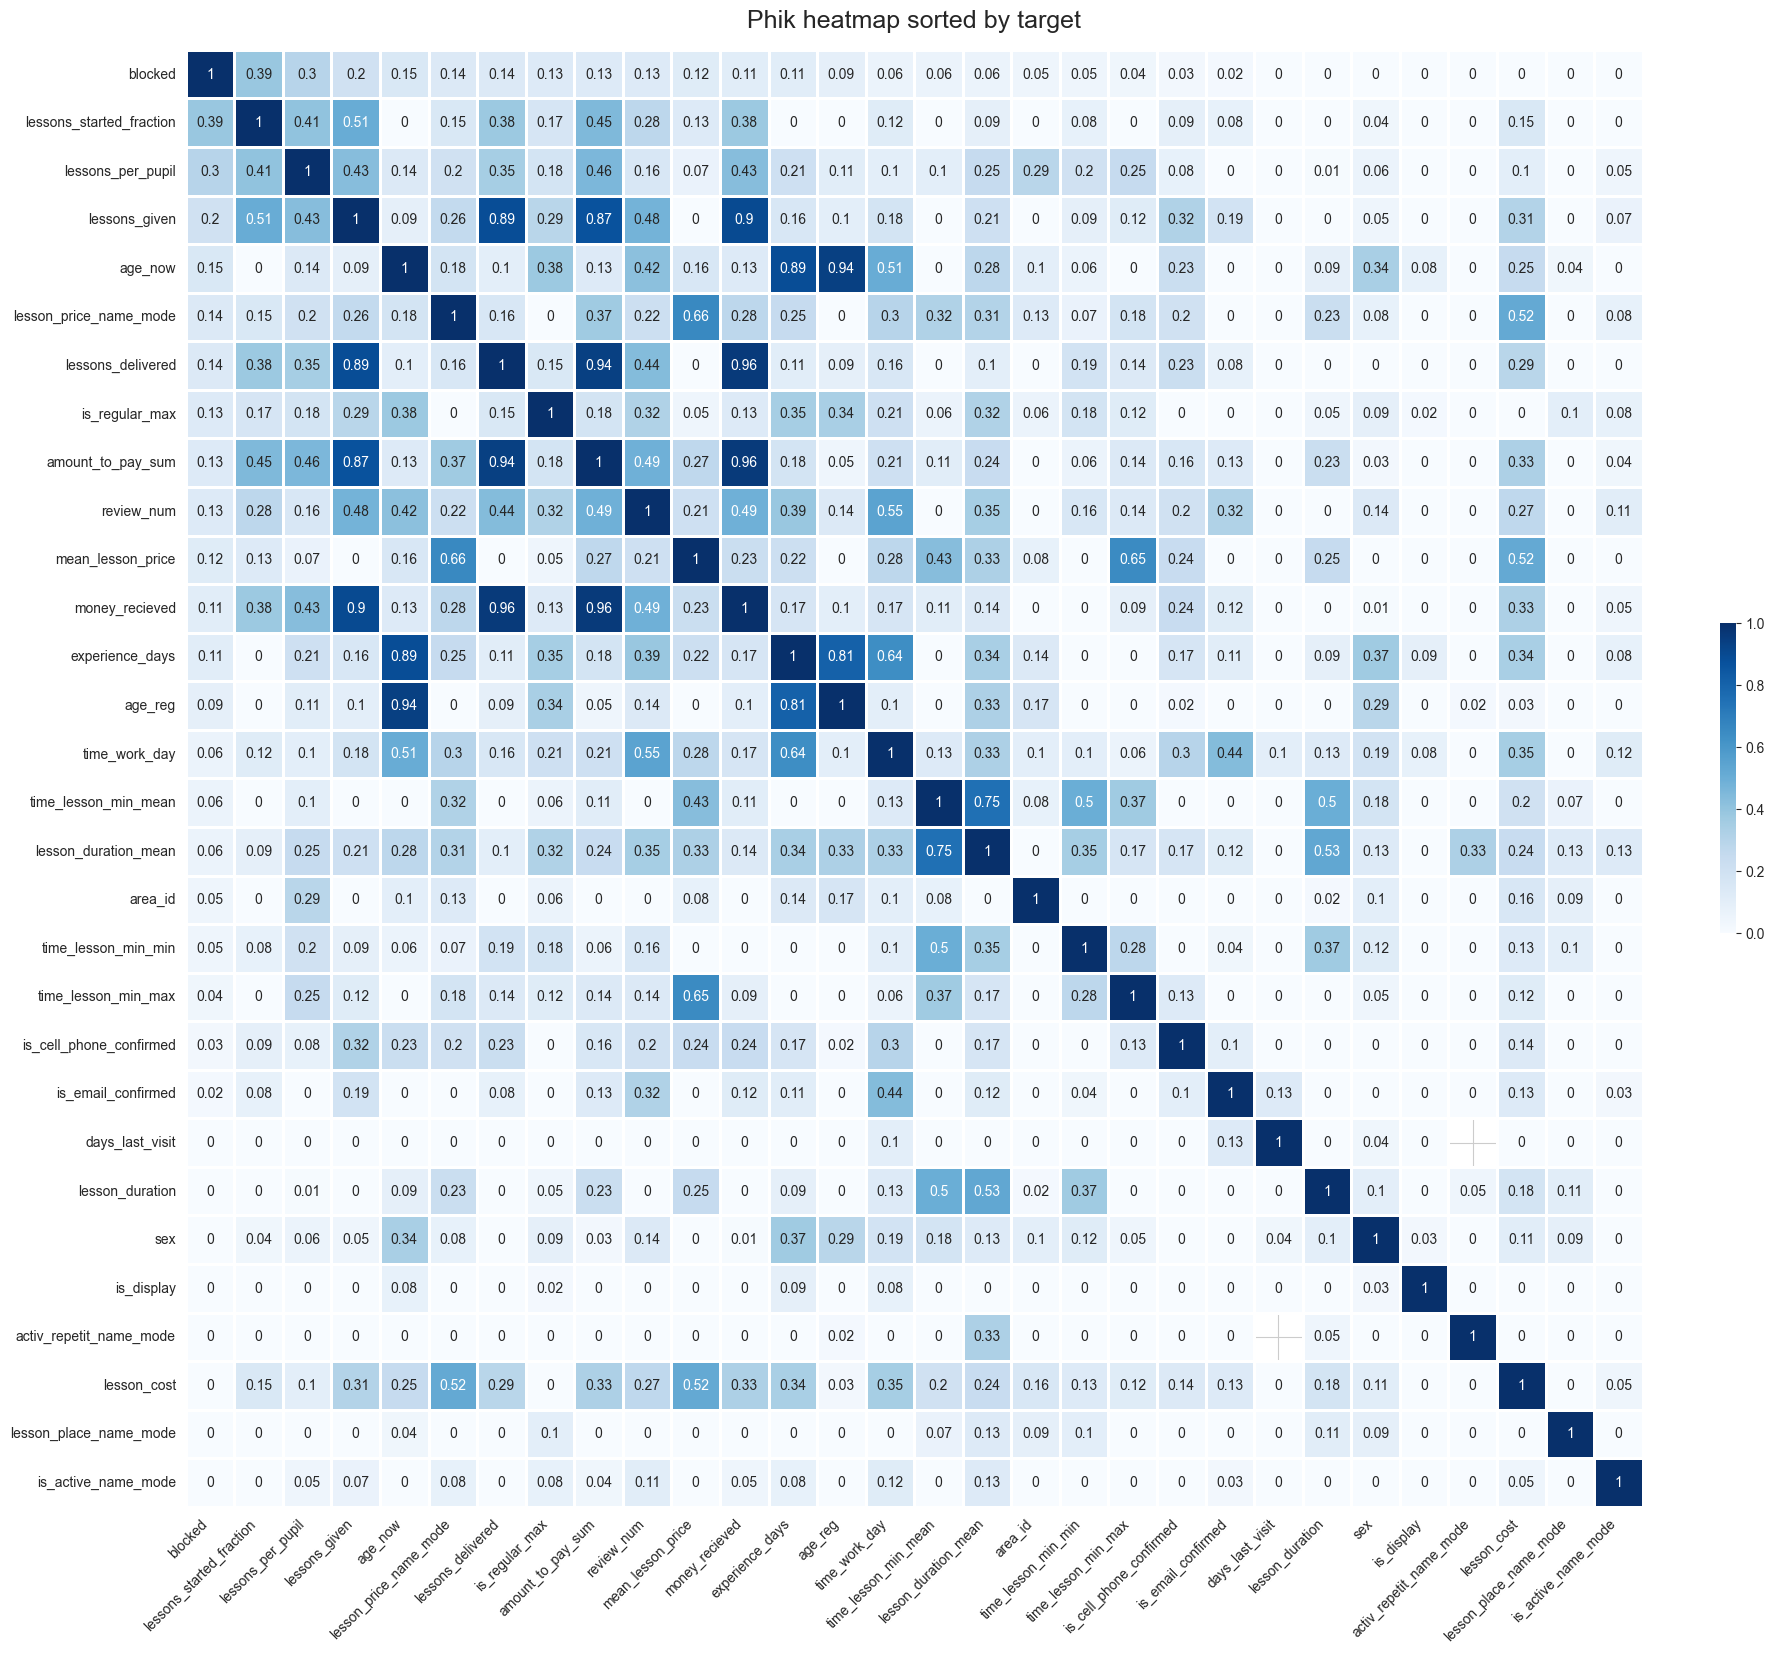

In [671]:
plt.figure(figsize=(20, 20))

sotred_columns = (
    teachers_lesson_df.phik_matrix(interval_cols=teachers_lesson_df.columns)
    .round(2)
    .sort_values("blocked", ascending=False, axis=1)
    .columns
)

heatmap = sns.heatmap(
    teachers_lesson_df.phik_matrix(interval_cols=teachers_lesson_df.columns)
    .round(2)
    .sort_values("blocked", ascending=False, axis=1)
    .reindex(sotred_columns),
    annot=True,
    square=True,
    cmap="Blues",
    vmax=1,
    vmin=0,
    cbar_kws={"fraction": 0.01},  # shrink colour bar
    linewidth=2,
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
)
heatmap.set_title("Phik heatmap sorted by target", fontdict={"fontsize": 18}, pad=16)
plt.show()

На таргет влияют такие показатели как  процент начала занятий, количество занятий на ученика, количество оплаченных уроков и д.р.. Между признаками тоже есть корреляция, уберём их

In [695]:
def corr_groups(df):
    cr = df.corr()
    cr = cr.abs().unstack()
    cr = cr.sort_values(ascending=False)
    cr = cr[cr >=0.85]
    cr = cr[cr < 1]
    cr = pd.DataFrame(cr).reset_index()
    cr['pair'] = cr[['level_0', 'level_1']].apply(lambda x: tuple(sorted(x)), axis=1)
    cr.drop_duplicates('pair', inplace=True)
    cr = cr.drop('pair', axis=1)
    cr.columns = ['one_feature', 'two_feature', 'corr']
    return cr

In [696]:
corr_groups(teachers_lesson_df)

,one_feature,two_feature,corr
0,age_reg,age_now,0.944113
2,amount_to_pay_sum,money_recieved,0.943010
4,lessons_given,money_recieved,0.923405
6,lessons_delivered,lessons_given,0.910366
8,amount_to_pay_sum,lessons_given,0.877649
10,experience_days,age_now,0.868578


In [697]:
teachers_lesson_df.drop(['age_reg', 'money_recieved', 'lessons_delivered', 'amount_to_pay_sum'], axis=1, inplace=True)

<Figure size 2000x500 with 0 Axes>

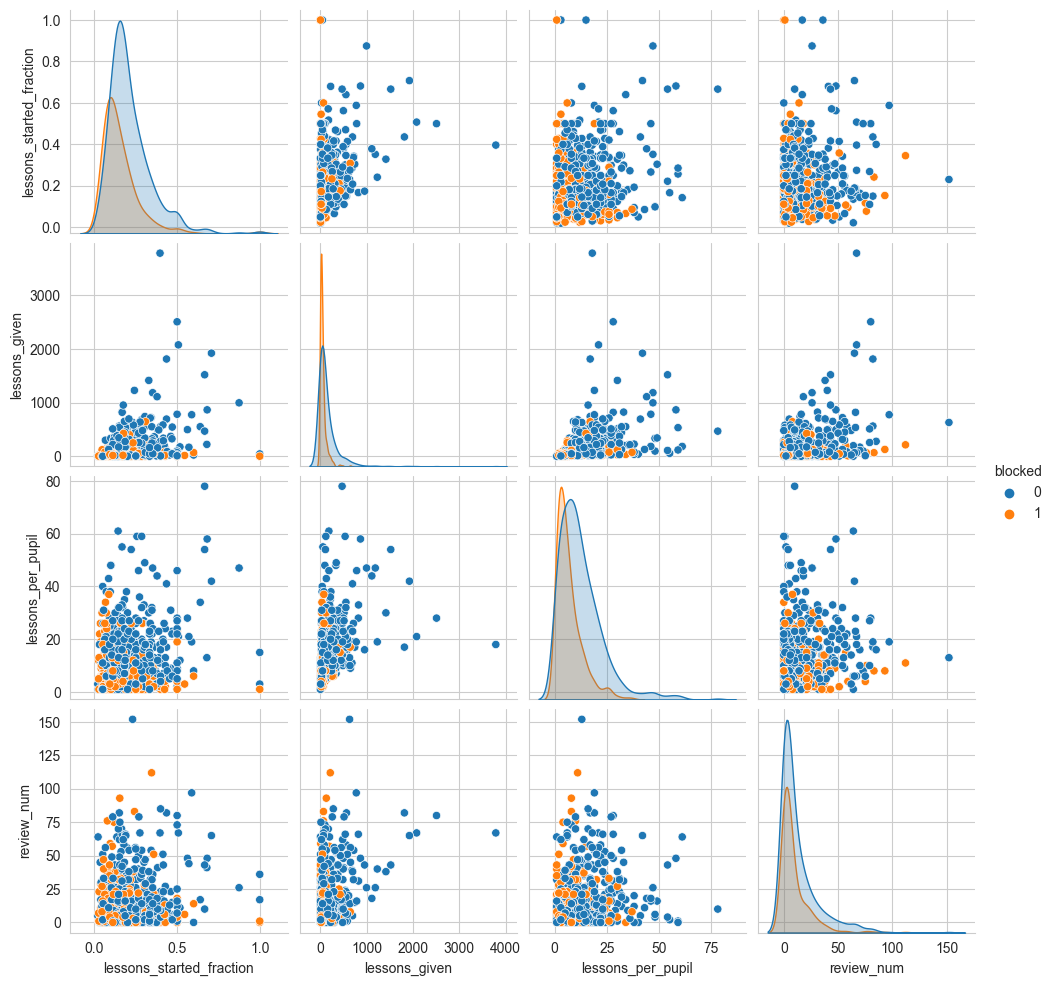

In [698]:
plt.figure(figsize=(20, 5))
sns.set_style("whitegrid")

sns.pairplot(
    teachers_lesson_df.sample(1000),
    vars=["lessons_started_fraction", "lessons_given", "lessons_per_pupil", "review_num"],
    hue="blocked",
)
plt.show()

In [699]:
teachers_lesson_df.head()

,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,blocked,is_email_confirmed,lesson_duration,lesson_cost,is_display,is_cell_phone_confirmed,area_id,sex,review_num,age_now,days_last_visit,time_work_day,experience_days,lesson_price_name_mode,time_lesson_min_mean,time_lesson_min_min,time_lesson_min_max,activ_repetit_name_mode,is_regular_max,lesson_place_name_mode,is_active_name_mode,lesson_duration_mean
0,1284.22,469,0.6667,78,0,0,60,800,1,0,2,1,10,26,523,1453,2399,1000,60.439331,60,120,1,0,4,1,60.062762
1,884.09,1082,0.3590,77,0,0,60,600,1,0,13,2,26,56,522,1986,14087,0,66.528497,30,165,1,1,4,1,7.335592
2,2500.00,184,0.1429,61,0,0,60,2500,1,0,2,2,64,58,522,4206,7878,2000,62.404459,30,90,1,1,4,1,27.515924
3,1879.34,363,0.1500,60,0,0,60,1500,1,0,1,2,10,37,741,2394,6782,1500,74.759358,60,90,1,1,4,1,70.556150
4,1252.43,534,0.2571,59,0,0,45,1178,1,0,116,2,1,50,NaN,434,11530,1500,56.361940,45,90,1,0,4,1,54.654851


In [820]:
teachers_lesson_df.loc[teachers_lesson_df.days_last_visit.isnull(), 'days_last_visit']  = teachers_lesson_df.days_last_visit.fillna(-1).astype('int')

В данных есть пропуски по колонке с последнем днём визита, убирать их не буду, так как данных не так и много, а для нас каждая строка важна, заполню значениями -1, предполагая, что человек мог просто зарегистрироваться и не заходить. Есть ещё вариант медианного заполнения, но видя первоначально, что этот признак имеет около нулевое влияние на таргет, заполним значениями -1.

### CatBoostClassifier <a id='8'></a>

In [931]:
X = teachers_lesson_df.drop('blocked', axis=1)
y = teachers_lesson_df['blocked']

cat_features = ['is_email_confirmed',  'is_display',	'is_cell_phone_confirmed',  'area_id', 'sex', 'activ_repetit_name_mode',	'is_regular_max',	'lesson_place_name_mode',	'is_active_name_mode']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [936]:
# задам параметры модели
model_catboost = CatBoostClassifier(
    iterations=100, early_stopping_rounds=25,
    random_state=42, cat_features=cat_features,
    eval_metric='F1', verbose=False)

# выбераю сетку гиперпараметров модели
param_grid_catboost = {'learning_rate': (0.01, 0.03, 0.06, 0.1)}

In [933]:
# соберем все вместе
model_catboost_result = model_catboost.grid_search( param_grid_catboost,  \
                                                   X_train,  y_train,  cv=3,   plot=True, \
                                                   refit=True,  search_by_train_test_split=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.5234899329
bestIteration = 6

Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.5369127517
bestIteration = 12

Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.5714285714
bestIteration = 67

Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.5695364238
bestIteration = 31

Training on fold [0/3]

bestTest = 0.531120332
bestIteration = 26

Training on fold [1/3]

bestTest = 0.56
bestIteration = 19

Training on fold [2/3]

bestTest = 0.5977011494
bestIteration = 47



Функция для вывода метрик обученной модели:

In [934]:
def get_metrics(model_catboost, X_test, y_test):
    # сохраняю предсказания и лучшие гиперпараметры
    proba_preds_test = model_catboost.predict_proba(X_test)
    preds_test = model_catboost.predict(X_test)
    catboost_best_params = model_catboost.get_params()

    # вывожу метрик
    catboost_metrics = pd.DataFrame(
        data={
            'ROC-AUC': [roc_auc_score(y_test, proba_preds_test[:, 1])], 
            'Precision': [precision_score(y_test, preds_test)],
            'Recall': [recall_score(y_test, preds_test)],
            'F1-score': [f1_score(y_test, preds_test)]
        }, 
        index=['test']
    )
    catboost_class_report = classification_report(y_test, preds_test, target_names=['0', '1'])
    
    display(catboost_metrics)
    print(catboost_class_report)

In [935]:
get_metrics(model_catboost, X_test, y_test)


,ROC-AUC,Precision,Recall,F1-score
test,0.769076,0.677419,0.543103,0.602871


              precision    recall  f1-score   support

           0       0.75      0.84      0.79       188
           1       0.68      0.54      0.60       116

    accuracy                           0.73       304
   macro avg       0.71      0.69      0.70       304
weighted avg       0.72      0.73      0.72       304



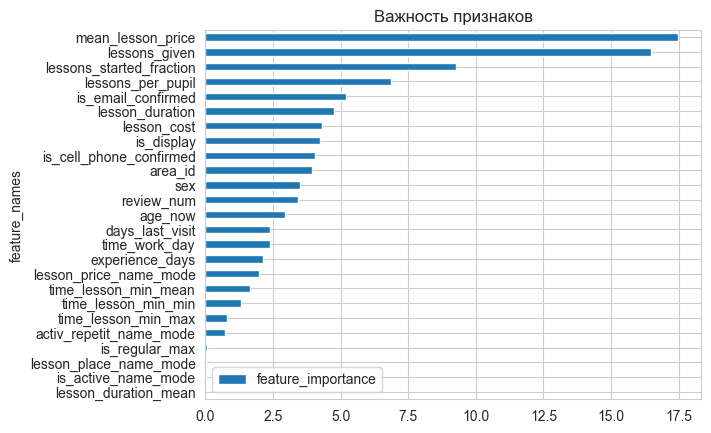

In [903]:
feature_df_cat = pd.DataFrame({'feature_importance': model_catboost.get_feature_importance(prettified=True)['Importances'], 
              'feature_names': X_test.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False).sort_values(by=['feature_importance'], ascending=True)
feature_df_cat.plot.barh(x='feature_names', y='feature_importance')
plt.title('Важность признаков')
plt.show()

В модели CatBoost сильное влияние на целевую переменную оказывают средняя цена урока, сколько оплачено, процент начала занятий, количество занятий на ученика, иные способы верификации и иное. В целом чем более активный репетитор, тем более большая вероятность моделиклассифицировать как добропорядочного и ответственного человека и наоборот.

### RandomForestClassifier <a id='9'></a>

In [878]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# evaluating the model
print("Testing Accuracy: ", model.score(X_test, y_test).round(3))

# classification report
cr = classification_report(y_test, y_pred)
print(cr)

Testing Accuracy:  0.671
              precision    recall  f1-score   support

           0       0.71      0.80      0.75       188
           1       0.59      0.47      0.52       116

    accuracy                           0.67       304
   macro avg       0.65      0.63      0.63       304
weighted avg       0.66      0.67      0.66       304



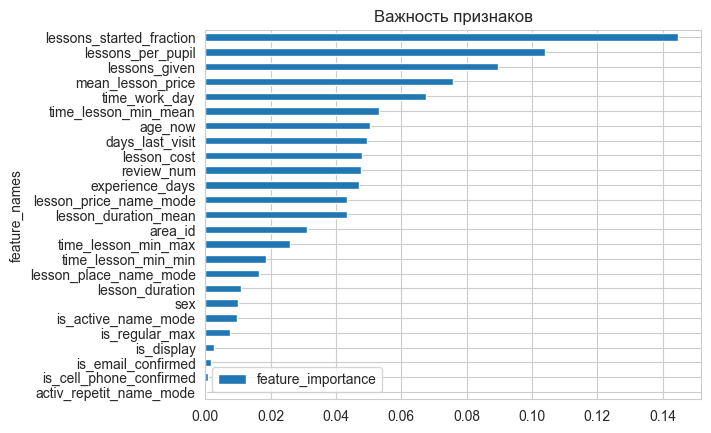

In [889]:
feature_df = pd.DataFrame({'feature_importance': model.feature_importances_, 
              'feature_names': X_test.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False).sort_values(by=['feature_importance'], ascending=True)
feature_df.plot.barh(x='feature_names', y='feature_importance')
plt.title('Важность признаков')
plt.show()

Попробуем скорректировать обучение модели исходя из важности признаков:

In [901]:
feature_list = feature_df['feature_names'][-8:].tolist()

In [902]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train[feature_list], y_train)

y_pred = model.predict(X_test[feature_list])

# evaluating the model
print("Testing Accuracy: ", model.score(X_test[feature_list], y_test).round(3))

# classification report
cr = classification_report(y_test, y_pred)
print(cr)

Testing Accuracy:  0.727
              precision    recall  f1-score   support

           0       0.76      0.81      0.79       188
           1       0.66      0.59      0.62       116

    accuracy                           0.73       304
   macro avg       0.71      0.70      0.70       304
weighted avg       0.72      0.73      0.72       304



Модель случайного леса определила в качестве первостепенного по важности признаков это процент начала занятий, далее число уроков на ученика оплату уроков и другие признаки. 

### Подведём итоги <a id='10'></a>

В данной работе мне предстояло разработать модель, которая по имеющейся информации о репетиторе и проведенных им занятий будет классифицировать репетиторов на платящих и неэффективных. Все таблицы были подробно рассмотрены, все признаки проанализированны. 
В целом обобщая все данные в предоставленных таблицах можно выделить следующее:
1. выбросы за рамками логики (например возраст более 100 и более лет и др.);
2. не корректные значения;
3. не соответствие типов данных и иное.

Были добавлены новые признаки в данные, на основе имеющихся, как количественные, так и категориальные.

В работе были использованы две модели (линейные не использовались, так как предполагалось за основу брать модель бустинга) RandomForestClassifier и CatBoostClassifier. Модель RandomForestClassifier показала чуть более лучший результат, чем CatBoost и после  тюнинга гиперпараметров и отбор только значимых признаков RandomForestClassifier показал лучшие результаты, достигнув F1 равного 0.72. Это свидетельствует о хорошей способности модели к разделению классов и обобщению на новые данные.
На предсказание модели влияют больше факты активности репетитора, то какое количество уроков он проводит, процент начатых занятий, количество уроков на ученика и т.п.. Также цены  на уроки более адекватные в своём сигменте, определённом предмете, предполагаю даёт больший процент начала занятий со стороны клиента, а значит повышаеется статистика активности, принесения прибыли бизнесу и отнесению его к классу платящих. 

Модель CatBoost требует дополнительного анализа ошибок, возможно вызванных несбалансированным распределением классов или наличием шума в данных.

Для улучшения предсказательной способности модели рекомендую:
1. Провести балансировку классов и посмотреть на качество модели. Дисбаланс примерно 1:2.
2. Создать новые признаки для более глубокого понимания структуры данных и улучшения качества предсказаний.
3. Собрать больше данных.
Это может  способствовать повышению точности модели в отношении предсказания классификации репетиторов и улучшить обобщающую способность модели.
